In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "int97"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 176
Categorical features: 7
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 248
Categorical Columns: 7


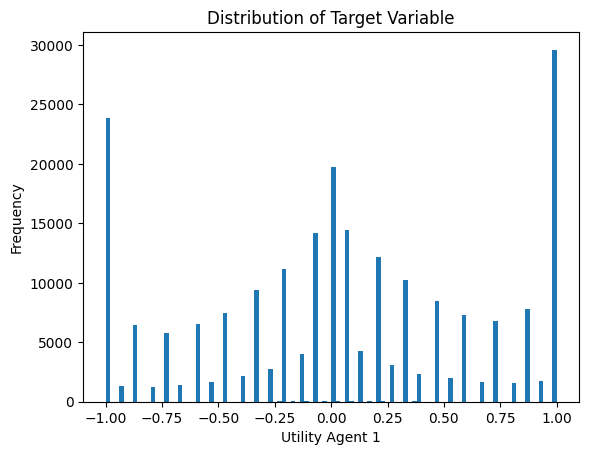

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.49404


[200]	valid_0's rmse: 0.475606


[300]	valid_0's rmse: 0.465322


[400]	valid_0's rmse: 0.458812


[500]	valid_0's rmse: 0.453276


[600]	valid_0's rmse: 0.449426


[700]	valid_0's rmse: 0.445973


[800]	valid_0's rmse: 0.443282


[900]	valid_0's rmse: 0.440818


[1000]	valid_0's rmse: 0.438874


[1100]	valid_0's rmse: 0.437491


[1200]	valid_0's rmse: 0.436155


[1300]	valid_0's rmse: 0.435016


[1400]	valid_0's rmse: 0.434116


[1500]	valid_0's rmse: 0.433282


[1600]	valid_0's rmse: 0.432557


[1700]	valid_0's rmse: 0.431684


[1800]	valid_0's rmse: 0.431111


[1900]	valid_0's rmse: 0.430567


[2000]	valid_0's rmse: 0.430097


[2100]	valid_0's rmse: 0.429538


[2200]	valid_0's rmse: 0.429014


[2300]	valid_0's rmse: 0.428573


[2400]	valid_0's rmse: 0.428195


[2500]	valid_0's rmse: 0.427771


[2600]	valid_0's rmse: 0.427439


[2700]	valid_0's rmse: 0.427086


[2800]	valid_0's rmse: 0.426834


[2900]	valid_0's rmse: 0.42638


[3000]	valid_0's rmse: 0.426184


[3100]	valid_0's rmse: 0.425954


[3200]	valid_0's rmse: 0.425773


[3300]	valid_0's rmse: 0.425602


[3400]	valid_0's rmse: 0.42538


[3500]	valid_0's rmse: 0.425249


[3600]	valid_0's rmse: 0.42508


[3700]	valid_0's rmse: 0.425007


[3800]	valid_0's rmse: 0.424849


[3900]	valid_0's rmse: 0.424703


[4000]	valid_0's rmse: 0.424493


[4100]	valid_0's rmse: 0.424351


[4200]	valid_0's rmse: 0.424243


[4300]	valid_0's rmse: 0.424202


[4400]	valid_0's rmse: 0.424085


[4500]	valid_0's rmse: 0.42397


[4600]	valid_0's rmse: 0.423944


[4700]	valid_0's rmse: 0.423895


[4800]	valid_0's rmse: 0.423786


[4900]	valid_0's rmse: 0.423726


[5000]	valid_0's rmse: 0.423708


[5100]	valid_0's rmse: 0.423613


[5200]	valid_0's rmse: 0.423631


[5300]	valid_0's rmse: 0.42359


[5400]	valid_0's rmse: 0.423498


[5500]	valid_0's rmse: 0.423437


[5600]	valid_0's rmse: 0.423392


[5700]	valid_0's rmse: 0.423339


[5800]	valid_0's rmse: 0.423239


[5900]	valid_0's rmse: 0.423297


[6000]	valid_0's rmse: 0.4233


[6100]	valid_0's rmse: 0.42327


[6200]	valid_0's rmse: 0.423202


[6300]	valid_0's rmse: 0.423225


[6400]	valid_0's rmse: 0.423215


[6500]	valid_0's rmse: 0.42326


[6600]	valid_0's rmse: 0.42322


[6700]	valid_0's rmse: 0.423231


[6800]	valid_0's rmse: 0.423277


[6900]	valid_0's rmse: 0.423259


[7000]	valid_0's rmse: 0.423194


[7100]	valid_0's rmse: 0.423195


[7200]	valid_0's rmse: 0.423168


[7300]	valid_0's rmse: 0.423146


[7400]	valid_0's rmse: 0.423132


[7500]	valid_0's rmse: 0.423143


[7600]	valid_0's rmse: 0.423216


[7700]	valid_0's rmse: 0.423199


[7800]	valid_0's rmse: 0.423129


[7900]	valid_0's rmse: 0.423077


[8000]	valid_0's rmse: 0.423055


[8100]	valid_0's rmse: 0.423013


[8200]	valid_0's rmse: 0.423003


[8300]	valid_0's rmse: 0.422986


[8400]	valid_0's rmse: 0.422954


[8500]	valid_0's rmse: 0.422951


[8600]	valid_0's rmse: 0.422939


[8700]	valid_0's rmse: 0.422908


[8800]	valid_0's rmse: 0.422862


[8900]	valid_0's rmse: 0.42287


[9000]	valid_0's rmse: 0.422948


[9100]	valid_0's rmse: 0.422932


[9200]	valid_0's rmse: 0.42298


[9300]	valid_0's rmse: 0.422942


[9400]	valid_0's rmse: 0.422981


[9500]	valid_0's rmse: 0.42294


[9600]	valid_0's rmse: 0.422932


[9700]	valid_0's rmse: 0.42295


[9800]	valid_0's rmse: 0.422983


[9900]	valid_0's rmse: 0.422983


[10000]	valid_0's rmse: 0.42297


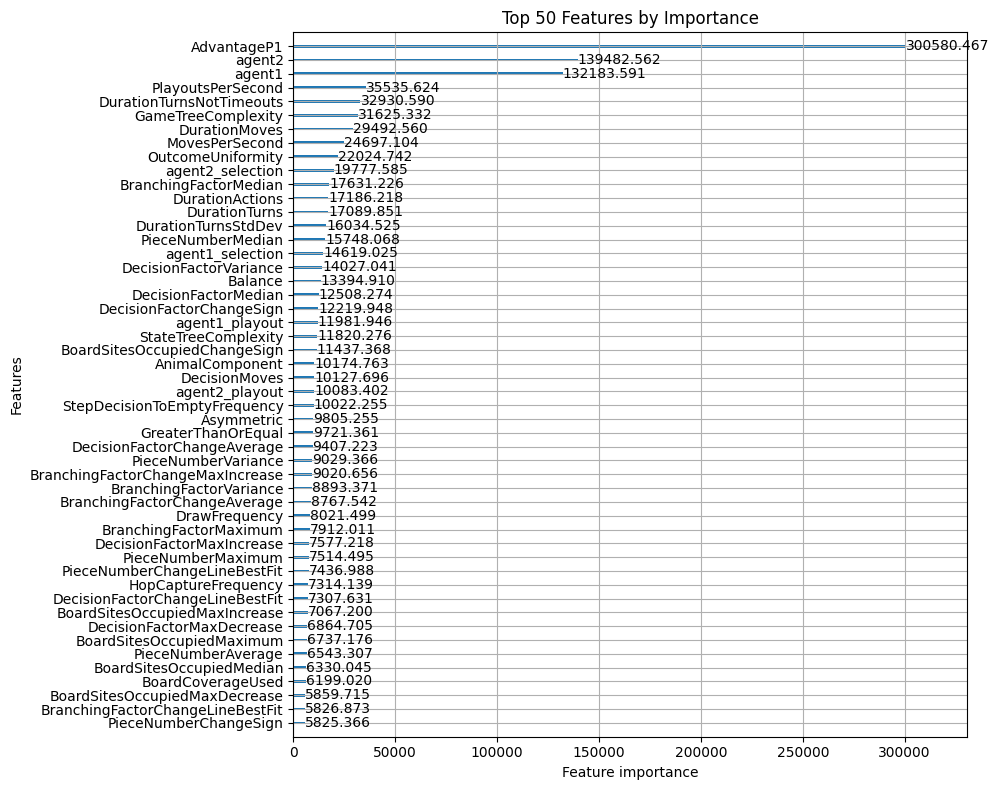

Fold 1 - RMSE: 0.42238735028240937
Fold 2


[100]	valid_0's rmse: 0.506761


[200]	valid_0's rmse: 0.490563


[300]	valid_0's rmse: 0.482776


[400]	valid_0's rmse: 0.47753


[500]	valid_0's rmse: 0.473614


[600]	valid_0's rmse: 0.470829


[700]	valid_0's rmse: 0.468301


[800]	valid_0's rmse: 0.465952


[900]	valid_0's rmse: 0.464389


[1000]	valid_0's rmse: 0.463391


[1100]	valid_0's rmse: 0.462391


[1200]	valid_0's rmse: 0.461443


[1300]	valid_0's rmse: 0.460414


[1400]	valid_0's rmse: 0.460232


[1500]	valid_0's rmse: 0.459778


[1600]	valid_0's rmse: 0.458989


[1700]	valid_0's rmse: 0.458594


[1800]	valid_0's rmse: 0.458104


[1900]	valid_0's rmse: 0.457608


[2000]	valid_0's rmse: 0.457126


[2100]	valid_0's rmse: 0.456676


[2200]	valid_0's rmse: 0.456126


[2300]	valid_0's rmse: 0.455586


[2400]	valid_0's rmse: 0.455233


[2500]	valid_0's rmse: 0.455004


[2600]	valid_0's rmse: 0.454536


[2700]	valid_0's rmse: 0.454369


[2800]	valid_0's rmse: 0.454202


[2900]	valid_0's rmse: 0.453865


[3000]	valid_0's rmse: 0.453544


[3100]	valid_0's rmse: 0.453304


[3200]	valid_0's rmse: 0.453166


[3300]	valid_0's rmse: 0.453009


[3400]	valid_0's rmse: 0.452771


[3500]	valid_0's rmse: 0.45256


[3600]	valid_0's rmse: 0.452387


[3700]	valid_0's rmse: 0.452261


[3800]	valid_0's rmse: 0.452172


[3900]	valid_0's rmse: 0.452074


[4000]	valid_0's rmse: 0.451944


[4100]	valid_0's rmse: 0.451882


[4200]	valid_0's rmse: 0.451859


[4300]	valid_0's rmse: 0.451727


[4400]	valid_0's rmse: 0.451679


[4500]	valid_0's rmse: 0.451546


[4600]	valid_0's rmse: 0.451473


[4700]	valid_0's rmse: 0.451352


[4800]	valid_0's rmse: 0.451171


[4900]	valid_0's rmse: 0.450996


[5000]	valid_0's rmse: 0.450814


[5100]	valid_0's rmse: 0.450725


[5200]	valid_0's rmse: 0.450618


[5300]	valid_0's rmse: 0.450472


[5400]	valid_0's rmse: 0.450433


[5500]	valid_0's rmse: 0.450411


[5600]	valid_0's rmse: 0.450439


[5700]	valid_0's rmse: 0.450295


[5800]	valid_0's rmse: 0.450231


[5900]	valid_0's rmse: 0.450097


[6000]	valid_0's rmse: 0.450001


[6100]	valid_0's rmse: 0.449949


[6200]	valid_0's rmse: 0.449821


[6300]	valid_0's rmse: 0.44978


[6400]	valid_0's rmse: 0.449735


[6500]	valid_0's rmse: 0.44976


[6600]	valid_0's rmse: 0.449758


[6700]	valid_0's rmse: 0.449661


[6800]	valid_0's rmse: 0.44965


[6900]	valid_0's rmse: 0.449567


[7000]	valid_0's rmse: 0.449482


[7100]	valid_0's rmse: 0.449427


[7200]	valid_0's rmse: 0.449456


[7300]	valid_0's rmse: 0.449396


[7400]	valid_0's rmse: 0.449348


[7500]	valid_0's rmse: 0.449333


[7600]	valid_0's rmse: 0.449381


[7700]	valid_0's rmse: 0.449316


[7800]	valid_0's rmse: 0.449228


[7900]	valid_0's rmse: 0.449212


[8000]	valid_0's rmse: 0.449217


[8100]	valid_0's rmse: 0.449179


[8200]	valid_0's rmse: 0.449149


[8300]	valid_0's rmse: 0.449045


[8400]	valid_0's rmse: 0.449008


[8500]	valid_0's rmse: 0.448954


[8600]	valid_0's rmse: 0.449009


[8700]	valid_0's rmse: 0.448967


[8800]	valid_0's rmse: 0.448899


[8900]	valid_0's rmse: 0.448895


[9000]	valid_0's rmse: 0.448936


[9100]	valid_0's rmse: 0.448933


[9200]	valid_0's rmse: 0.448927


[9300]	valid_0's rmse: 0.448867


[9400]	valid_0's rmse: 0.448891


[9500]	valid_0's rmse: 0.448864


[9600]	valid_0's rmse: 0.448839


[9700]	valid_0's rmse: 0.448818


[9800]	valid_0's rmse: 0.448778


[9900]	valid_0's rmse: 0.448742


[10000]	valid_0's rmse: 0.448747


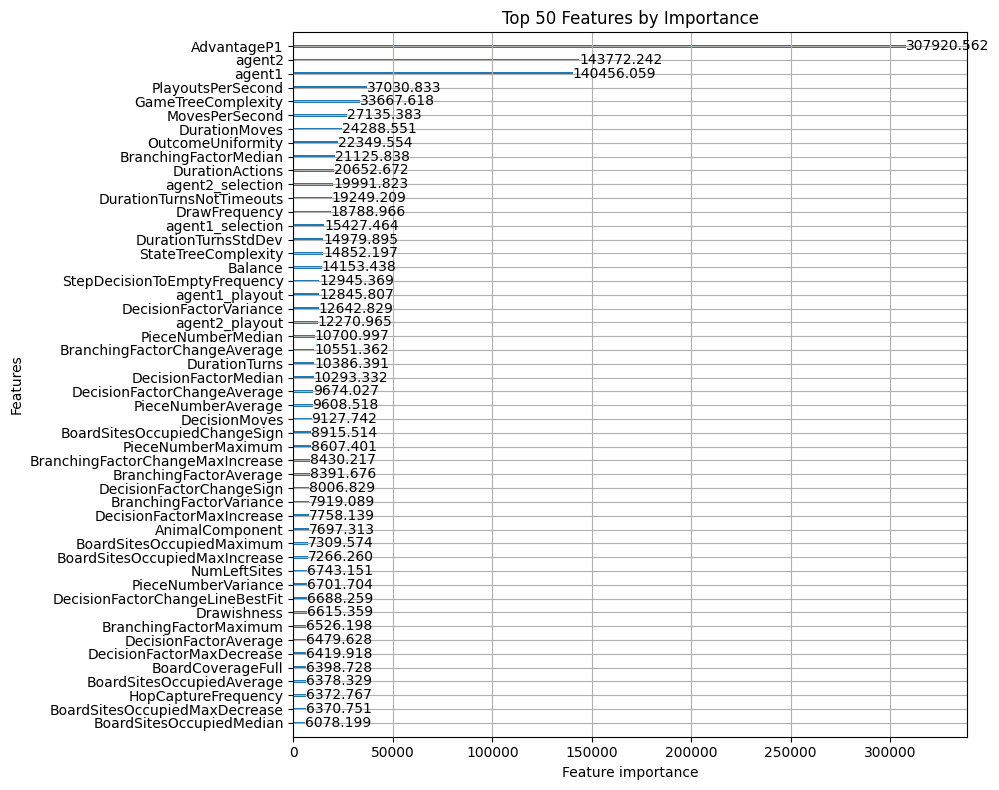

Fold 2 - RMSE: 0.448070578626634
Fold 3


[100]	valid_0's rmse: 0.511405


[200]	valid_0's rmse: 0.484739


[300]	valid_0's rmse: 0.474736


[400]	valid_0's rmse: 0.468381


[500]	valid_0's rmse: 0.465513


[600]	valid_0's rmse: 0.462508


[700]	valid_0's rmse: 0.460028


[800]	valid_0's rmse: 0.457361


[900]	valid_0's rmse: 0.455033


[1000]	valid_0's rmse: 0.453227


[1100]	valid_0's rmse: 0.452106


[1200]	valid_0's rmse: 0.450975


[1300]	valid_0's rmse: 0.45014


[1400]	valid_0's rmse: 0.44931


[1500]	valid_0's rmse: 0.448574


[1600]	valid_0's rmse: 0.447831


[1700]	valid_0's rmse: 0.447234


[1800]	valid_0's rmse: 0.446781


[1900]	valid_0's rmse: 0.446278


[2000]	valid_0's rmse: 0.445928


[2100]	valid_0's rmse: 0.445442


[2200]	valid_0's rmse: 0.445095


[2300]	valid_0's rmse: 0.444844


[2400]	valid_0's rmse: 0.444617


[2500]	valid_0's rmse: 0.444298


[2600]	valid_0's rmse: 0.444055


[2700]	valid_0's rmse: 0.443788


[2800]	valid_0's rmse: 0.443545


[2900]	valid_0's rmse: 0.443363


[3000]	valid_0's rmse: 0.44315


[3100]	valid_0's rmse: 0.443027


[3200]	valid_0's rmse: 0.442903


[3300]	valid_0's rmse: 0.442655


[3400]	valid_0's rmse: 0.442498


[3500]	valid_0's rmse: 0.442306


[3600]	valid_0's rmse: 0.442027


[3700]	valid_0's rmse: 0.441852


[3800]	valid_0's rmse: 0.441727


[3900]	valid_0's rmse: 0.441599


[4000]	valid_0's rmse: 0.441574


[4100]	valid_0's rmse: 0.441487


[4200]	valid_0's rmse: 0.441286


[4300]	valid_0's rmse: 0.441226


[4400]	valid_0's rmse: 0.441105


[4500]	valid_0's rmse: 0.440923


[4600]	valid_0's rmse: 0.440924


[4700]	valid_0's rmse: 0.440875


[4800]	valid_0's rmse: 0.440844


[4900]	valid_0's rmse: 0.44065


[5000]	valid_0's rmse: 0.440506


[5100]	valid_0's rmse: 0.440486


[5200]	valid_0's rmse: 0.44045


[5300]	valid_0's rmse: 0.44037


[5400]	valid_0's rmse: 0.440292


[5500]	valid_0's rmse: 0.440113


[5600]	valid_0's rmse: 0.440087


[5700]	valid_0's rmse: 0.440052


[5800]	valid_0's rmse: 0.439963


[5900]	valid_0's rmse: 0.439894


[6000]	valid_0's rmse: 0.439905


[6100]	valid_0's rmse: 0.439818


[6200]	valid_0's rmse: 0.439794


[6300]	valid_0's rmse: 0.439745


[6400]	valid_0's rmse: 0.439695


[6500]	valid_0's rmse: 0.439654


[6600]	valid_0's rmse: 0.439558


[6700]	valid_0's rmse: 0.439487


[6800]	valid_0's rmse: 0.439463


[6900]	valid_0's rmse: 0.439405


[7000]	valid_0's rmse: 0.439414


[7100]	valid_0's rmse: 0.439405


[7200]	valid_0's rmse: 0.439351


[7300]	valid_0's rmse: 0.439296


[7400]	valid_0's rmse: 0.439227


[7500]	valid_0's rmse: 0.43922


[7600]	valid_0's rmse: 0.439239


[7700]	valid_0's rmse: 0.439192


[7800]	valid_0's rmse: 0.439186


[7900]	valid_0's rmse: 0.439143


[8000]	valid_0's rmse: 0.439109


[8100]	valid_0's rmse: 0.43901


[8200]	valid_0's rmse: 0.438915


[8300]	valid_0's rmse: 0.438849


[8400]	valid_0's rmse: 0.438817


[8500]	valid_0's rmse: 0.438793


[8600]	valid_0's rmse: 0.438778


[8700]	valid_0's rmse: 0.438719


[8800]	valid_0's rmse: 0.438758


[8900]	valid_0's rmse: 0.438701


[9000]	valid_0's rmse: 0.438634


[9100]	valid_0's rmse: 0.438648


[9200]	valid_0's rmse: 0.438621


[9300]	valid_0's rmse: 0.438578


[9400]	valid_0's rmse: 0.438583


[9500]	valid_0's rmse: 0.438603


[9600]	valid_0's rmse: 0.43853


[9700]	valid_0's rmse: 0.438582


[9800]	valid_0's rmse: 0.438574


[9900]	valid_0's rmse: 0.438586


[10000]	valid_0's rmse: 0.438589


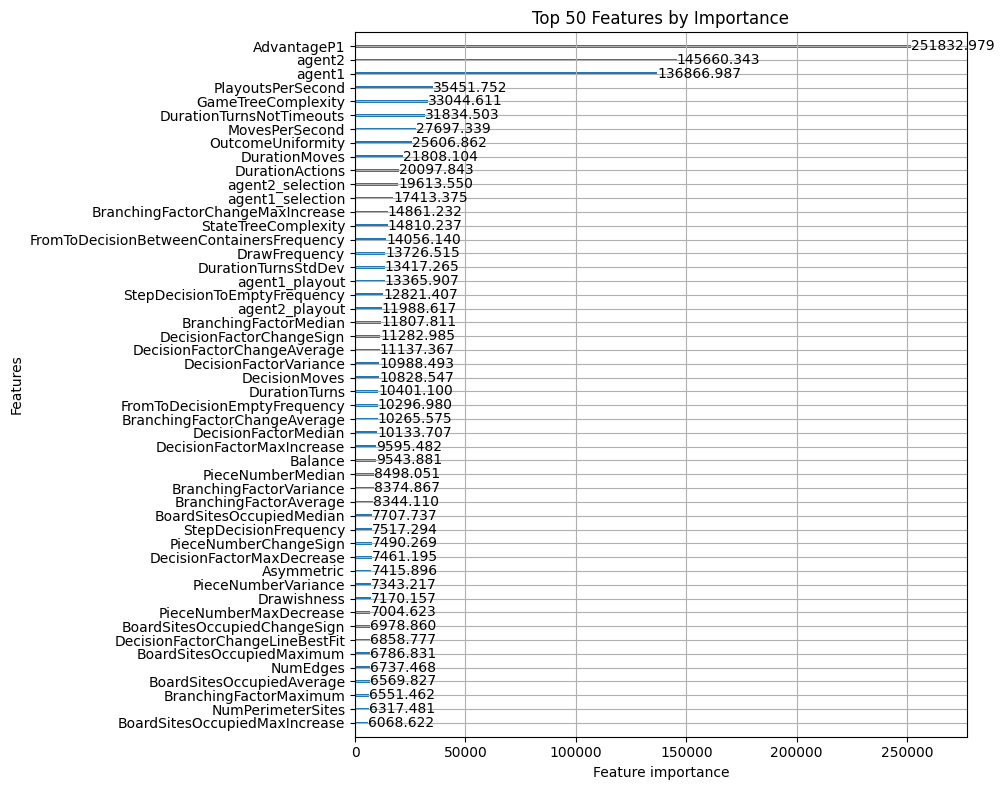

Fold 3 - RMSE: 0.43785200388784196
Fold 4


[100]	valid_0's rmse: 0.513693


[200]	valid_0's rmse: 0.49015


[300]	valid_0's rmse: 0.478664


[400]	valid_0's rmse: 0.470833


[500]	valid_0's rmse: 0.465342


[600]	valid_0's rmse: 0.46074


[700]	valid_0's rmse: 0.457383


[800]	valid_0's rmse: 0.45469


[900]	valid_0's rmse: 0.453118


[1000]	valid_0's rmse: 0.451045


[1100]	valid_0's rmse: 0.449585


[1200]	valid_0's rmse: 0.448746


[1300]	valid_0's rmse: 0.44775


[1400]	valid_0's rmse: 0.447126


[1500]	valid_0's rmse: 0.446443


[1600]	valid_0's rmse: 0.44568


[1700]	valid_0's rmse: 0.445072


[1800]	valid_0's rmse: 0.444381


[1900]	valid_0's rmse: 0.44368


[2000]	valid_0's rmse: 0.443242


[2100]	valid_0's rmse: 0.442673


[2200]	valid_0's rmse: 0.442122


[2300]	valid_0's rmse: 0.441793


[2400]	valid_0's rmse: 0.44156


[2500]	valid_0's rmse: 0.441181


[2600]	valid_0's rmse: 0.440838


[2700]	valid_0's rmse: 0.440647


[2800]	valid_0's rmse: 0.44033


[2900]	valid_0's rmse: 0.440027


[3000]	valid_0's rmse: 0.439814


[3100]	valid_0's rmse: 0.439568


[3200]	valid_0's rmse: 0.43934


[3300]	valid_0's rmse: 0.439076


[3400]	valid_0's rmse: 0.438935


[3500]	valid_0's rmse: 0.438781


[3600]	valid_0's rmse: 0.438683


[3700]	valid_0's rmse: 0.43853


[3800]	valid_0's rmse: 0.438384


[3900]	valid_0's rmse: 0.438224


[4000]	valid_0's rmse: 0.438051


[4100]	valid_0's rmse: 0.437951


[4200]	valid_0's rmse: 0.437738


[4300]	valid_0's rmse: 0.437645


[4400]	valid_0's rmse: 0.437531


[4500]	valid_0's rmse: 0.437452


[4600]	valid_0's rmse: 0.437302


[4700]	valid_0's rmse: 0.437255


[4800]	valid_0's rmse: 0.437137


[4900]	valid_0's rmse: 0.437088


[5000]	valid_0's rmse: 0.437044


[5100]	valid_0's rmse: 0.43694


[5200]	valid_0's rmse: 0.436883


[5300]	valid_0's rmse: 0.436774


[5400]	valid_0's rmse: 0.436798


[5500]	valid_0's rmse: 0.436736


[5600]	valid_0's rmse: 0.436618


[5700]	valid_0's rmse: 0.436514


[5800]	valid_0's rmse: 0.436414


[5900]	valid_0's rmse: 0.436397


[6000]	valid_0's rmse: 0.436296


[6100]	valid_0's rmse: 0.43626


[6200]	valid_0's rmse: 0.436202


[6300]	valid_0's rmse: 0.436215


[6400]	valid_0's rmse: 0.436227


[6500]	valid_0's rmse: 0.436226


[6600]	valid_0's rmse: 0.436165


[6700]	valid_0's rmse: 0.436093


[6800]	valid_0's rmse: 0.436023


[6900]	valid_0's rmse: 0.436016


[7000]	valid_0's rmse: 0.435945


[7100]	valid_0's rmse: 0.43592


[7200]	valid_0's rmse: 0.435888


[7300]	valid_0's rmse: 0.435837


[7400]	valid_0's rmse: 0.435756


[7500]	valid_0's rmse: 0.435767


[7600]	valid_0's rmse: 0.435678


[7700]	valid_0's rmse: 0.43567


[7800]	valid_0's rmse: 0.435654


[7900]	valid_0's rmse: 0.435636


[8000]	valid_0's rmse: 0.435615


[8100]	valid_0's rmse: 0.43561


[8200]	valid_0's rmse: 0.43559


[8300]	valid_0's rmse: 0.435564


[8400]	valid_0's rmse: 0.435589


[8500]	valid_0's rmse: 0.435596


[8600]	valid_0's rmse: 0.435562


[8700]	valid_0's rmse: 0.435561


[8800]	valid_0's rmse: 0.435546


[8900]	valid_0's rmse: 0.435513


[9000]	valid_0's rmse: 0.435447


[9100]	valid_0's rmse: 0.435412


[9200]	valid_0's rmse: 0.435407


[9300]	valid_0's rmse: 0.435359


[9400]	valid_0's rmse: 0.435342


[9500]	valid_0's rmse: 0.435332


[9600]	valid_0's rmse: 0.435299


[9700]	valid_0's rmse: 0.435297


[9800]	valid_0's rmse: 0.435272


[9900]	valid_0's rmse: 0.435281


[10000]	valid_0's rmse: 0.435289


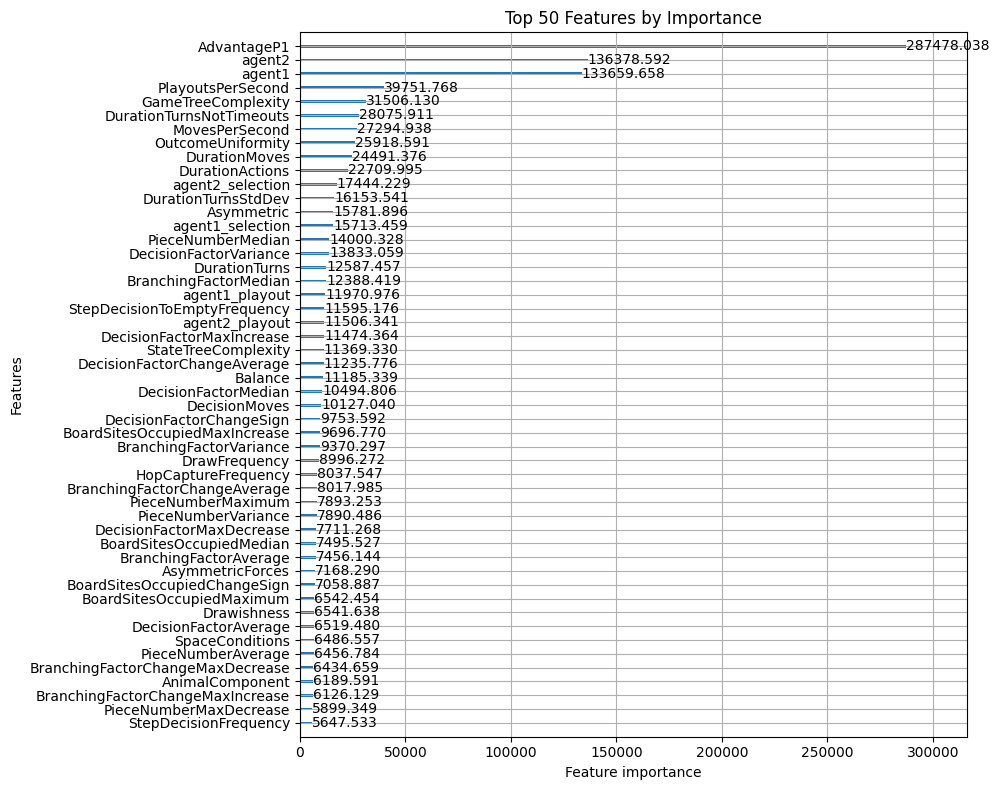

Fold 4 - RMSE: 0.4344370252904492
Fold 5


[100]	valid_0's rmse: 0.487231


[200]	valid_0's rmse: 0.464655


[300]	valid_0's rmse: 0.453581


[400]	valid_0's rmse: 0.443866


[500]	valid_0's rmse: 0.437888


[600]	valid_0's rmse: 0.432511


[700]	valid_0's rmse: 0.428844


[800]	valid_0's rmse: 0.425717


[900]	valid_0's rmse: 0.423311


[1000]	valid_0's rmse: 0.42138


[1100]	valid_0's rmse: 0.419692


[1200]	valid_0's rmse: 0.418132


[1300]	valid_0's rmse: 0.417162


[1400]	valid_0's rmse: 0.416049


[1500]	valid_0's rmse: 0.415177


[1600]	valid_0's rmse: 0.414336


[1700]	valid_0's rmse: 0.413661


[1800]	valid_0's rmse: 0.413075


[1900]	valid_0's rmse: 0.412535


[2000]	valid_0's rmse: 0.411973


[2100]	valid_0's rmse: 0.411487


[2200]	valid_0's rmse: 0.410958


[2300]	valid_0's rmse: 0.410504


[2400]	valid_0's rmse: 0.409969


[2500]	valid_0's rmse: 0.409569


[2600]	valid_0's rmse: 0.409137


[2700]	valid_0's rmse: 0.408736


[2800]	valid_0's rmse: 0.408296


[2900]	valid_0's rmse: 0.407926


[3000]	valid_0's rmse: 0.407688


[3100]	valid_0's rmse: 0.407367


[3200]	valid_0's rmse: 0.407185


[3300]	valid_0's rmse: 0.407014


[3400]	valid_0's rmse: 0.406709


[3500]	valid_0's rmse: 0.406473


[3600]	valid_0's rmse: 0.406329


[3700]	valid_0's rmse: 0.406137


[3800]	valid_0's rmse: 0.40597


[3900]	valid_0's rmse: 0.405777


[4000]	valid_0's rmse: 0.405597


[4100]	valid_0's rmse: 0.405459


[4200]	valid_0's rmse: 0.405322


[4300]	valid_0's rmse: 0.405091


[4400]	valid_0's rmse: 0.405022


[4500]	valid_0's rmse: 0.40485


[4600]	valid_0's rmse: 0.404774


[4700]	valid_0's rmse: 0.40463


[4800]	valid_0's rmse: 0.404565


[4900]	valid_0's rmse: 0.404474


[5000]	valid_0's rmse: 0.40446


[5100]	valid_0's rmse: 0.404468


[5200]	valid_0's rmse: 0.404364


[5300]	valid_0's rmse: 0.404278


[5400]	valid_0's rmse: 0.404173


[5500]	valid_0's rmse: 0.404214


[5600]	valid_0's rmse: 0.404175


[5700]	valid_0's rmse: 0.404082


[5800]	valid_0's rmse: 0.404117


[5900]	valid_0's rmse: 0.404071


[6000]	valid_0's rmse: 0.404068


[6100]	valid_0's rmse: 0.403997


[6200]	valid_0's rmse: 0.403893


[6300]	valid_0's rmse: 0.403847


[6400]	valid_0's rmse: 0.403822


[6500]	valid_0's rmse: 0.403729


[6600]	valid_0's rmse: 0.403722


[6700]	valid_0's rmse: 0.403676


[6800]	valid_0's rmse: 0.403599


[6900]	valid_0's rmse: 0.403532


[7000]	valid_0's rmse: 0.403504


[7100]	valid_0's rmse: 0.403465


[7200]	valid_0's rmse: 0.40343


[7300]	valid_0's rmse: 0.403388


[7400]	valid_0's rmse: 0.403312


[7500]	valid_0's rmse: 0.403292


[7600]	valid_0's rmse: 0.403251


[7700]	valid_0's rmse: 0.403241


[7800]	valid_0's rmse: 0.403227


[7900]	valid_0's rmse: 0.403207


[8000]	valid_0's rmse: 0.40317


[8100]	valid_0's rmse: 0.403145


[8200]	valid_0's rmse: 0.403102


[8300]	valid_0's rmse: 0.403134


[8400]	valid_0's rmse: 0.403134


[8500]	valid_0's rmse: 0.40311


[8600]	valid_0's rmse: 0.403125


[8700]	valid_0's rmse: 0.40308


[8800]	valid_0's rmse: 0.403111


[8900]	valid_0's rmse: 0.403139


[9000]	valid_0's rmse: 0.40312


[9100]	valid_0's rmse: 0.403133


[9200]	valid_0's rmse: 0.40311


[9300]	valid_0's rmse: 0.403099


[9400]	valid_0's rmse: 0.403077


[9500]	valid_0's rmse: 0.403089


[9600]	valid_0's rmse: 0.403132


[9700]	valid_0's rmse: 0.403168


[9800]	valid_0's rmse: 0.403179


[9900]	valid_0's rmse: 0.403162


[10000]	valid_0's rmse: 0.40317


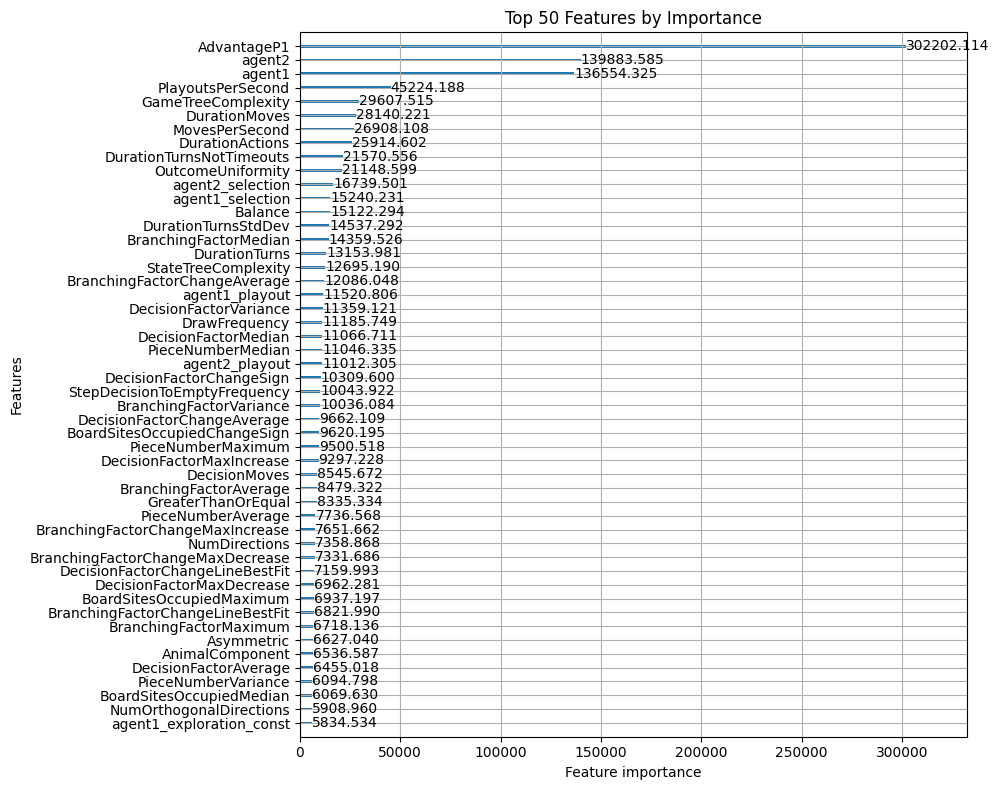

Fold 5 - RMSE: 0.4027249096089737
List of oof scores: [0.42238735028240937, 0.448070578626634, 0.43785200388784196, 0.4344370252904492, 0.4027249096089737]
Average oof score: 0.42909437353926166


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.47728


[200]	valid_0's rmse: 0.4578


[300]	valid_0's rmse: 0.448747


[400]	valid_0's rmse: 0.442043


[500]	valid_0's rmse: 0.437414


[600]	valid_0's rmse: 0.433751


[700]	valid_0's rmse: 0.431322


[800]	valid_0's rmse: 0.429235


[900]	valid_0's rmse: 0.427385


[1000]	valid_0's rmse: 0.425938


[1100]	valid_0's rmse: 0.424734


[1200]	valid_0's rmse: 0.423821


[1300]	valid_0's rmse: 0.423089


[1400]	valid_0's rmse: 0.422463


[1500]	valid_0's rmse: 0.421648


[1600]	valid_0's rmse: 0.420798


[1700]	valid_0's rmse: 0.42036


[1800]	valid_0's rmse: 0.41975


[1900]	valid_0's rmse: 0.419368


[2000]	valid_0's rmse: 0.418982


[2100]	valid_0's rmse: 0.418581


[2200]	valid_0's rmse: 0.418227


[2300]	valid_0's rmse: 0.417923


[2400]	valid_0's rmse: 0.41765


[2500]	valid_0's rmse: 0.417303


[2600]	valid_0's rmse: 0.417009


[2700]	valid_0's rmse: 0.41678


[2800]	valid_0's rmse: 0.416551


[2900]	valid_0's rmse: 0.416343


[3000]	valid_0's rmse: 0.416064


[3100]	valid_0's rmse: 0.415757


[3200]	valid_0's rmse: 0.415644


[3300]	valid_0's rmse: 0.415529


[3400]	valid_0's rmse: 0.415266


[3500]	valid_0's rmse: 0.415061


[3600]	valid_0's rmse: 0.414921


[3700]	valid_0's rmse: 0.414713


[3800]	valid_0's rmse: 0.414471


[3900]	valid_0's rmse: 0.414315


[4000]	valid_0's rmse: 0.414175


[4100]	valid_0's rmse: 0.413958


[4200]	valid_0's rmse: 0.413784


[4300]	valid_0's rmse: 0.413659


[4400]	valid_0's rmse: 0.413445


[4500]	valid_0's rmse: 0.413427


[4600]	valid_0's rmse: 0.413257


[4700]	valid_0's rmse: 0.413102


[4800]	valid_0's rmse: 0.412948


[4900]	valid_0's rmse: 0.412893


[5000]	valid_0's rmse: 0.412874


[5100]	valid_0's rmse: 0.412764


[5200]	valid_0's rmse: 0.412702


[5300]	valid_0's rmse: 0.412555


[5400]	valid_0's rmse: 0.412466


[5500]	valid_0's rmse: 0.412384


[5600]	valid_0's rmse: 0.412305


[5700]	valid_0's rmse: 0.412312


[5800]	valid_0's rmse: 0.412281


[5900]	valid_0's rmse: 0.412178


[6000]	valid_0's rmse: 0.41213


[6100]	valid_0's rmse: 0.412089


[6200]	valid_0's rmse: 0.412043


[6300]	valid_0's rmse: 0.412024


[6400]	valid_0's rmse: 0.411928


[6500]	valid_0's rmse: 0.411883


[6600]	valid_0's rmse: 0.41191


[6700]	valid_0's rmse: 0.411835


[6800]	valid_0's rmse: 0.411819


[6900]	valid_0's rmse: 0.411743


[7000]	valid_0's rmse: 0.411759


[7100]	valid_0's rmse: 0.411658


[7200]	valid_0's rmse: 0.411614


[7300]	valid_0's rmse: 0.411632


[7400]	valid_0's rmse: 0.411583


[7500]	valid_0's rmse: 0.411489


[7600]	valid_0's rmse: 0.41146


[7700]	valid_0's rmse: 0.411527


[7800]	valid_0's rmse: 0.411446


[7900]	valid_0's rmse: 0.411452


[8000]	valid_0's rmse: 0.411459


[8100]	valid_0's rmse: 0.411459


[8200]	valid_0's rmse: 0.411418


[8300]	valid_0's rmse: 0.411382


[8400]	valid_0's rmse: 0.411345


[8500]	valid_0's rmse: 0.411344


[8600]	valid_0's rmse: 0.411287


[8700]	valid_0's rmse: 0.411251


[8800]	valid_0's rmse: 0.411204


[8900]	valid_0's rmse: 0.411185


[9000]	valid_0's rmse: 0.411167


[9100]	valid_0's rmse: 0.411097


[9200]	valid_0's rmse: 0.411091


[9300]	valid_0's rmse: 0.411027


[9400]	valid_0's rmse: 0.411015


[9500]	valid_0's rmse: 0.41097


[9600]	valid_0's rmse: 0.410939


[9700]	valid_0's rmse: 0.410952


[9800]	valid_0's rmse: 0.410956


[9900]	valid_0's rmse: 0.41091


[10000]	valid_0's rmse: 0.410891


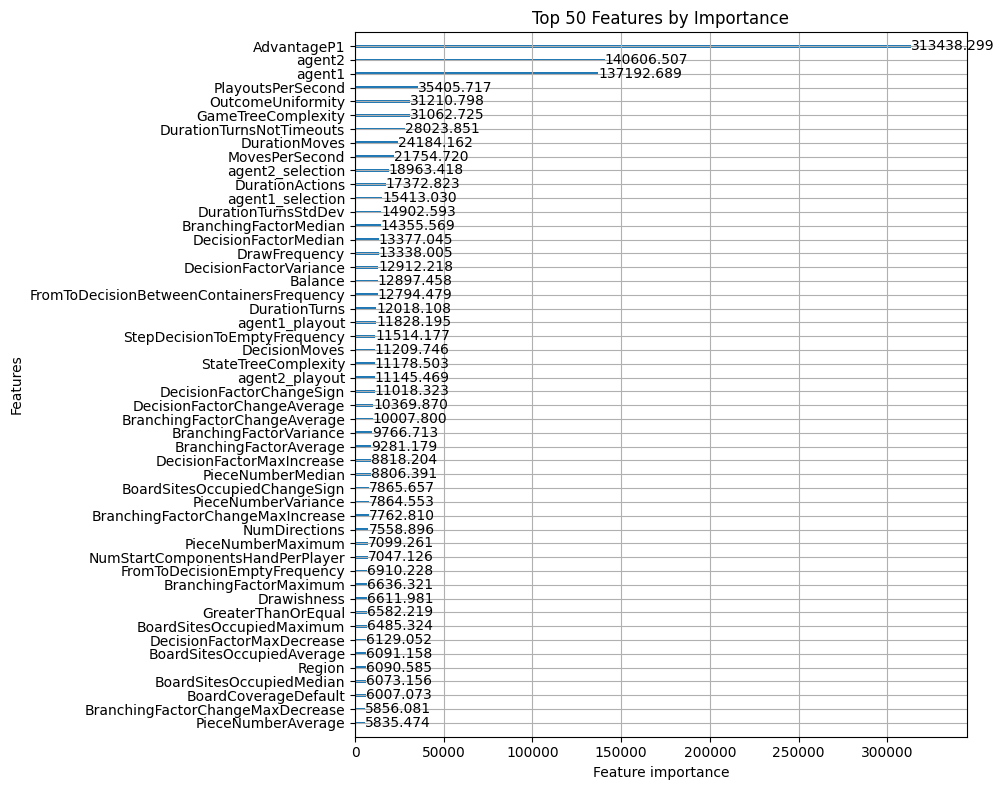

Fold 1 - RMSE: 0.41042524972721095
Fold 2


[100]	valid_0's rmse: 0.457481


[200]	valid_0's rmse: 0.437771


[300]	valid_0's rmse: 0.429221


[400]	valid_0's rmse: 0.423296


[500]	valid_0's rmse: 0.420404


[600]	valid_0's rmse: 0.417856


[700]	valid_0's rmse: 0.415921


[800]	valid_0's rmse: 0.414303


[900]	valid_0's rmse: 0.412781


[1000]	valid_0's rmse: 0.411515


[1100]	valid_0's rmse: 0.410549


[1200]	valid_0's rmse: 0.409784


[1300]	valid_0's rmse: 0.409151


[1400]	valid_0's rmse: 0.408487


[1500]	valid_0's rmse: 0.407771


[1600]	valid_0's rmse: 0.407119


[1700]	valid_0's rmse: 0.406704


[1800]	valid_0's rmse: 0.406126


[1900]	valid_0's rmse: 0.405903


[2000]	valid_0's rmse: 0.40562


[2100]	valid_0's rmse: 0.405212


[2200]	valid_0's rmse: 0.405007


[2300]	valid_0's rmse: 0.404796


[2400]	valid_0's rmse: 0.404654


[2500]	valid_0's rmse: 0.404487


[2600]	valid_0's rmse: 0.40429


[2700]	valid_0's rmse: 0.403979


[2800]	valid_0's rmse: 0.403828


[2900]	valid_0's rmse: 0.40372


[3000]	valid_0's rmse: 0.403522


[3100]	valid_0's rmse: 0.403297


[3200]	valid_0's rmse: 0.403209


[3300]	valid_0's rmse: 0.403131


[3400]	valid_0's rmse: 0.402947


[3500]	valid_0's rmse: 0.402789


[3600]	valid_0's rmse: 0.402724


[3700]	valid_0's rmse: 0.402699


[3800]	valid_0's rmse: 0.402453


[3900]	valid_0's rmse: 0.402227


[4000]	valid_0's rmse: 0.402203


[4100]	valid_0's rmse: 0.402159


[4200]	valid_0's rmse: 0.402112


[4300]	valid_0's rmse: 0.402173


[4400]	valid_0's rmse: 0.4021


[4500]	valid_0's rmse: 0.402056


[4600]	valid_0's rmse: 0.401939


[4700]	valid_0's rmse: 0.401952


[4800]	valid_0's rmse: 0.401927


[4900]	valid_0's rmse: 0.401874


[5000]	valid_0's rmse: 0.401888


[5100]	valid_0's rmse: 0.401849


[5200]	valid_0's rmse: 0.401809


[5300]	valid_0's rmse: 0.401713


[5400]	valid_0's rmse: 0.401652


[5500]	valid_0's rmse: 0.401642


[5600]	valid_0's rmse: 0.401697


[5700]	valid_0's rmse: 0.40161


[5800]	valid_0's rmse: 0.401615


[5900]	valid_0's rmse: 0.401614


[6000]	valid_0's rmse: 0.40161


[6100]	valid_0's rmse: 0.401573


[6200]	valid_0's rmse: 0.401535


[6300]	valid_0's rmse: 0.401515


[6400]	valid_0's rmse: 0.401562


[6500]	valid_0's rmse: 0.401655


[6600]	valid_0's rmse: 0.401606


[6700]	valid_0's rmse: 0.401626


[6800]	valid_0's rmse: 0.401601


[6900]	valid_0's rmse: 0.401575


[7000]	valid_0's rmse: 0.401597


[7100]	valid_0's rmse: 0.401584


[7200]	valid_0's rmse: 0.401622


[7300]	valid_0's rmse: 0.401637


[7400]	valid_0's rmse: 0.401638


[7500]	valid_0's rmse: 0.401695


[7600]	valid_0's rmse: 0.401688


[7700]	valid_0's rmse: 0.401733


[7800]	valid_0's rmse: 0.401741


[7900]	valid_0's rmse: 0.401712


[8000]	valid_0's rmse: 0.401769


[8100]	valid_0's rmse: 0.40178


[8200]	valid_0's rmse: 0.401816


[8300]	valid_0's rmse: 0.40183


[8400]	valid_0's rmse: 0.401813


[8500]	valid_0's rmse: 0.401848


[8600]	valid_0's rmse: 0.40188


[8700]	valid_0's rmse: 0.401801


[8800]	valid_0's rmse: 0.401804


[8900]	valid_0's rmse: 0.401738


[9000]	valid_0's rmse: 0.401737


[9100]	valid_0's rmse: 0.401759


[9200]	valid_0's rmse: 0.401749


[9300]	valid_0's rmse: 0.401737


[9400]	valid_0's rmse: 0.401786


[9500]	valid_0's rmse: 0.401819


[9600]	valid_0's rmse: 0.401798


[9700]	valid_0's rmse: 0.401818


[9800]	valid_0's rmse: 0.401811


[9900]	valid_0's rmse: 0.401889


[10000]	valid_0's rmse: 0.401943


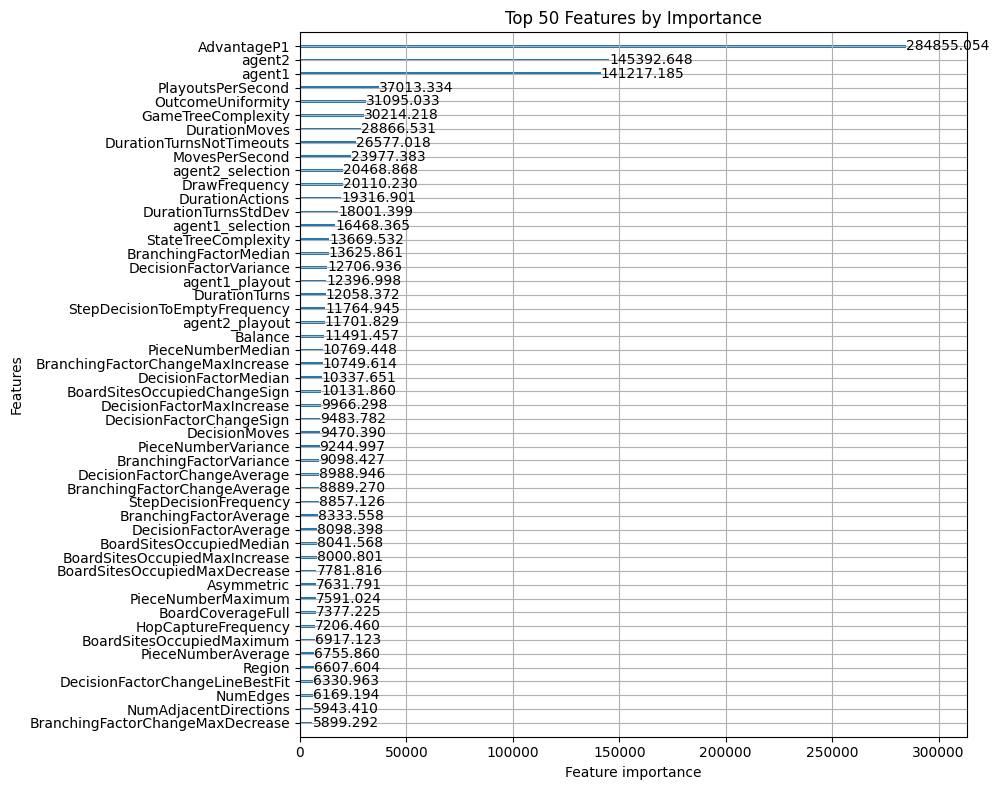

Fold 2 - RMSE: 0.4012625334315349
Fold 3


[100]	valid_0's rmse: 0.522574


[200]	valid_0's rmse: 0.495373


[300]	valid_0's rmse: 0.482167


[400]	valid_0's rmse: 0.473805


[500]	valid_0's rmse: 0.467837


[600]	valid_0's rmse: 0.463001


[700]	valid_0's rmse: 0.459577


[800]	valid_0's rmse: 0.456174


[900]	valid_0's rmse: 0.454082


[1000]	valid_0's rmse: 0.452107


[1100]	valid_0's rmse: 0.450339


[1200]	valid_0's rmse: 0.448711


[1300]	valid_0's rmse: 0.447285


[1400]	valid_0's rmse: 0.446191


[1500]	valid_0's rmse: 0.445084


[1600]	valid_0's rmse: 0.444042


[1700]	valid_0's rmse: 0.443307


[1800]	valid_0's rmse: 0.44252


[1900]	valid_0's rmse: 0.441855


[2000]	valid_0's rmse: 0.441378


[2100]	valid_0's rmse: 0.440789


[2200]	valid_0's rmse: 0.440389


[2300]	valid_0's rmse: 0.439797


[2400]	valid_0's rmse: 0.439276


[2500]	valid_0's rmse: 0.438876


[2600]	valid_0's rmse: 0.438462


[2700]	valid_0's rmse: 0.438092


[2800]	valid_0's rmse: 0.437748


[2900]	valid_0's rmse: 0.437432


[3000]	valid_0's rmse: 0.43711


[3100]	valid_0's rmse: 0.436872


[3200]	valid_0's rmse: 0.43655


[3300]	valid_0's rmse: 0.436309


[3400]	valid_0's rmse: 0.435987


[3500]	valid_0's rmse: 0.435701


[3600]	valid_0's rmse: 0.435567


[3700]	valid_0's rmse: 0.435387


[3800]	valid_0's rmse: 0.435181


[3900]	valid_0's rmse: 0.435073


[4000]	valid_0's rmse: 0.434974


[4100]	valid_0's rmse: 0.434848


[4200]	valid_0's rmse: 0.434743


[4300]	valid_0's rmse: 0.434496


[4400]	valid_0's rmse: 0.434373


[4500]	valid_0's rmse: 0.434268


[4600]	valid_0's rmse: 0.434066


[4700]	valid_0's rmse: 0.434058


[4800]	valid_0's rmse: 0.433937


[4900]	valid_0's rmse: 0.43387


[5000]	valid_0's rmse: 0.433749


[5100]	valid_0's rmse: 0.433669


[5200]	valid_0's rmse: 0.433491


[5300]	valid_0's rmse: 0.433305


[5400]	valid_0's rmse: 0.433262


[5500]	valid_0's rmse: 0.433144


[5600]	valid_0's rmse: 0.433073


[5700]	valid_0's rmse: 0.433004


[5800]	valid_0's rmse: 0.432882


[5900]	valid_0's rmse: 0.432836


[6000]	valid_0's rmse: 0.432753


[6100]	valid_0's rmse: 0.432651


[6200]	valid_0's rmse: 0.432595


[6300]	valid_0's rmse: 0.432448


[6400]	valid_0's rmse: 0.432335


[6500]	valid_0's rmse: 0.432278


[6600]	valid_0's rmse: 0.432173


[6700]	valid_0's rmse: 0.432143


[6800]	valid_0's rmse: 0.432068


[6900]	valid_0's rmse: 0.432018


[7000]	valid_0's rmse: 0.431974


[7100]	valid_0's rmse: 0.431938


[7200]	valid_0's rmse: 0.431822


[7300]	valid_0's rmse: 0.43176


[7400]	valid_0's rmse: 0.431658


[7500]	valid_0's rmse: 0.431639


[7600]	valid_0's rmse: 0.431569


[7700]	valid_0's rmse: 0.431524


[7800]	valid_0's rmse: 0.431518


[7900]	valid_0's rmse: 0.431499


[8000]	valid_0's rmse: 0.431452


[8100]	valid_0's rmse: 0.431506


[8200]	valid_0's rmse: 0.431405


[8300]	valid_0's rmse: 0.431332


[8400]	valid_0's rmse: 0.431319


[8500]	valid_0's rmse: 0.431314


[8600]	valid_0's rmse: 0.431286


[8700]	valid_0's rmse: 0.431261


[8800]	valid_0's rmse: 0.431226


[8900]	valid_0's rmse: 0.43122


[9000]	valid_0's rmse: 0.431194


[9100]	valid_0's rmse: 0.431135


[9200]	valid_0's rmse: 0.431012


[9300]	valid_0's rmse: 0.431047


[9400]	valid_0's rmse: 0.430974


[9500]	valid_0's rmse: 0.430952


[9600]	valid_0's rmse: 0.430893


[9700]	valid_0's rmse: 0.43089


[9800]	valid_0's rmse: 0.430855


[9900]	valid_0's rmse: 0.430827


[10000]	valid_0's rmse: 0.430803


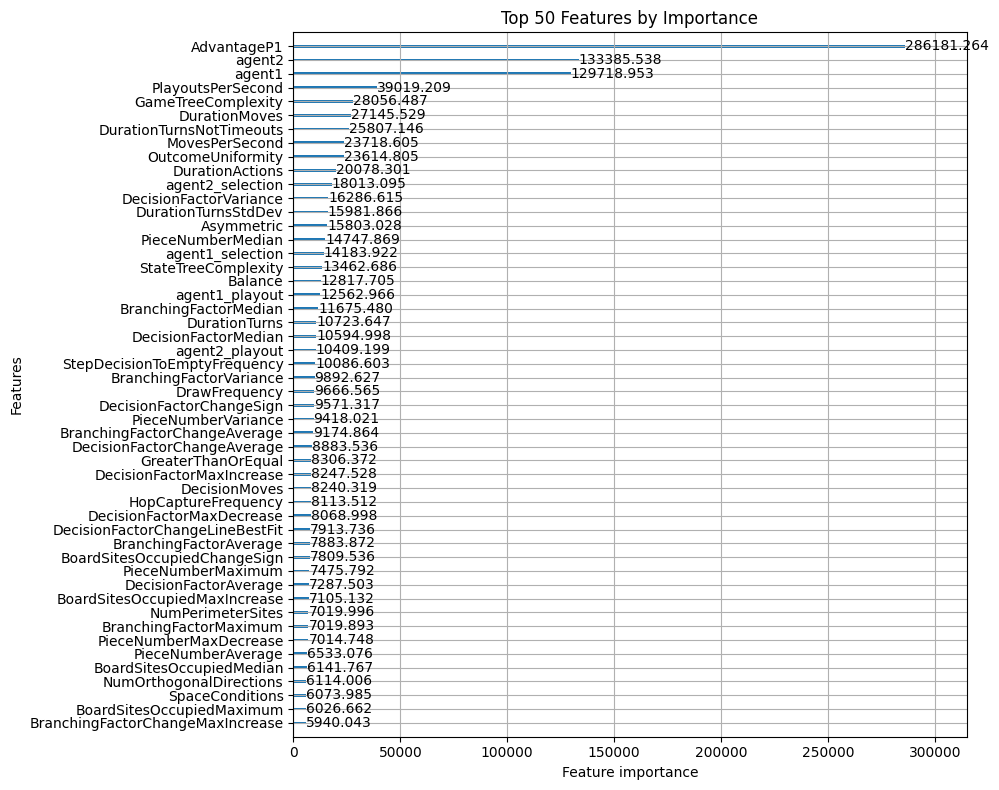

Fold 3 - RMSE: 0.42989848789168794
Fold 4


[100]	valid_0's rmse: 0.520974


[200]	valid_0's rmse: 0.495855


[300]	valid_0's rmse: 0.48324


[400]	valid_0's rmse: 0.47438


[500]	valid_0's rmse: 0.468526


[600]	valid_0's rmse: 0.465785


[700]	valid_0's rmse: 0.462584


[800]	valid_0's rmse: 0.460287


[900]	valid_0's rmse: 0.458318


[1000]	valid_0's rmse: 0.456612


[1100]	valid_0's rmse: 0.455351


[1200]	valid_0's rmse: 0.45405


[1300]	valid_0's rmse: 0.453034


[1400]	valid_0's rmse: 0.4521


[1500]	valid_0's rmse: 0.451292


[1600]	valid_0's rmse: 0.450605


[1700]	valid_0's rmse: 0.450049


[1800]	valid_0's rmse: 0.449407


[1900]	valid_0's rmse: 0.448737


[2000]	valid_0's rmse: 0.448187


[2100]	valid_0's rmse: 0.447707


[2200]	valid_0's rmse: 0.447316


[2300]	valid_0's rmse: 0.446847


[2400]	valid_0's rmse: 0.446504


[2500]	valid_0's rmse: 0.446129


[2600]	valid_0's rmse: 0.445741


[2700]	valid_0's rmse: 0.445422


[2800]	valid_0's rmse: 0.445074


[2900]	valid_0's rmse: 0.44488


[3000]	valid_0's rmse: 0.444719


[3100]	valid_0's rmse: 0.444437


[3200]	valid_0's rmse: 0.444214


[3300]	valid_0's rmse: 0.444031


[3400]	valid_0's rmse: 0.443897


[3500]	valid_0's rmse: 0.443774


[3600]	valid_0's rmse: 0.443646


[3700]	valid_0's rmse: 0.443496


[3800]	valid_0's rmse: 0.443318


[3900]	valid_0's rmse: 0.443123


[4000]	valid_0's rmse: 0.443066


[4100]	valid_0's rmse: 0.442964


[4200]	valid_0's rmse: 0.442823


[4300]	valid_0's rmse: 0.442708


[4400]	valid_0's rmse: 0.442562


[4500]	valid_0's rmse: 0.442481


[4600]	valid_0's rmse: 0.442411


[4700]	valid_0's rmse: 0.44228


[4800]	valid_0's rmse: 0.442145


[4900]	valid_0's rmse: 0.442019


[5000]	valid_0's rmse: 0.441957


[5100]	valid_0's rmse: 0.441887


[5200]	valid_0's rmse: 0.441772


[5300]	valid_0's rmse: 0.441674


[5400]	valid_0's rmse: 0.441605


[5500]	valid_0's rmse: 0.441503


[5600]	valid_0's rmse: 0.44139


[5700]	valid_0's rmse: 0.441346


[5800]	valid_0's rmse: 0.441279


[5900]	valid_0's rmse: 0.441175


[6000]	valid_0's rmse: 0.441177


[6100]	valid_0's rmse: 0.44112


[6200]	valid_0's rmse: 0.44115


[6300]	valid_0's rmse: 0.441079


[6400]	valid_0's rmse: 0.440991


[6500]	valid_0's rmse: 0.440898


[6600]	valid_0's rmse: 0.440872


[6700]	valid_0's rmse: 0.440828


[6800]	valid_0's rmse: 0.440721


[6900]	valid_0's rmse: 0.440693


[7000]	valid_0's rmse: 0.440653


[7100]	valid_0's rmse: 0.440629


[7200]	valid_0's rmse: 0.440512


[7300]	valid_0's rmse: 0.440413


[7400]	valid_0's rmse: 0.440348


[7500]	valid_0's rmse: 0.440289


[7600]	valid_0's rmse: 0.440255


[7700]	valid_0's rmse: 0.440194


[7800]	valid_0's rmse: 0.440188


[7900]	valid_0's rmse: 0.44015


[8000]	valid_0's rmse: 0.440082


[8100]	valid_0's rmse: 0.44004


[8200]	valid_0's rmse: 0.440031


[8300]	valid_0's rmse: 0.439989


[8400]	valid_0's rmse: 0.439965


[8500]	valid_0's rmse: 0.439888


[8600]	valid_0's rmse: 0.43988


[8700]	valid_0's rmse: 0.439932


[8800]	valid_0's rmse: 0.439889


[8900]	valid_0's rmse: 0.439895


[9000]	valid_0's rmse: 0.439844


[9100]	valid_0's rmse: 0.439776


[9200]	valid_0's rmse: 0.439745


[9300]	valid_0's rmse: 0.439734


[9400]	valid_0's rmse: 0.439667


[9500]	valid_0's rmse: 0.43963


[9600]	valid_0's rmse: 0.439532


[9700]	valid_0's rmse: 0.439548


[9800]	valid_0's rmse: 0.439505


[9900]	valid_0's rmse: 0.439516


[10000]	valid_0's rmse: 0.439483


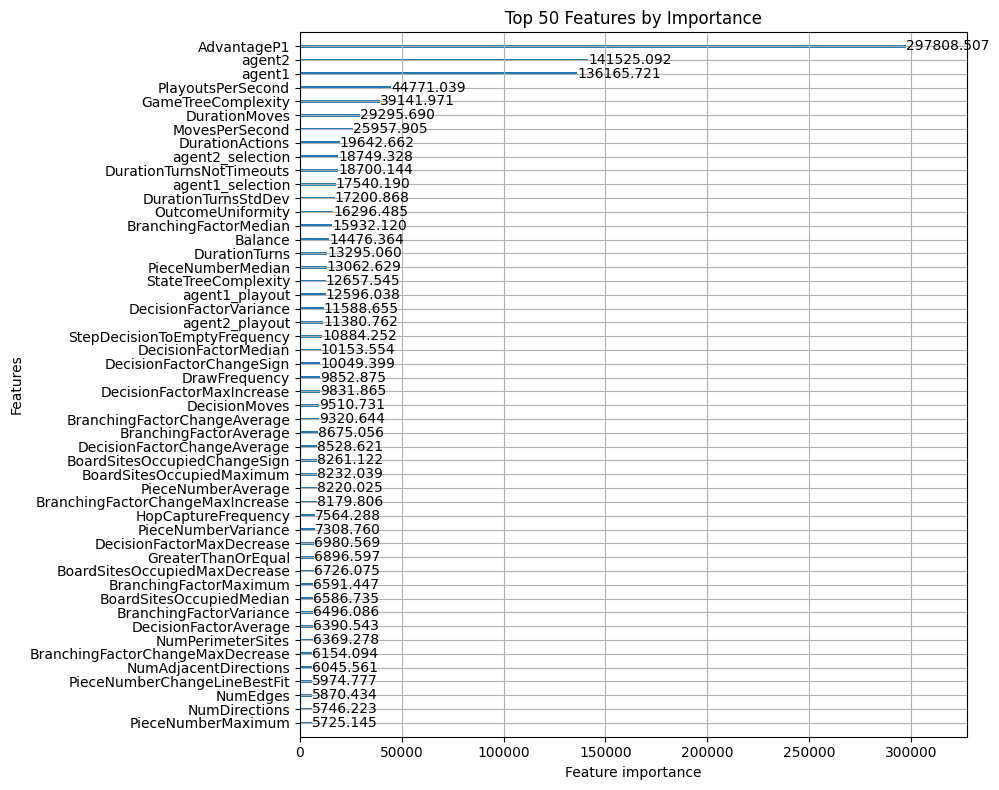

Fold 4 - RMSE: 0.43909968447386855
Fold 5


[100]	valid_0's rmse: 0.516675


[200]	valid_0's rmse: 0.494307


[300]	valid_0's rmse: 0.481303


[400]	valid_0's rmse: 0.471833


[500]	valid_0's rmse: 0.466418


[600]	valid_0's rmse: 0.462174


[700]	valid_0's rmse: 0.458524


[800]	valid_0's rmse: 0.455683


[900]	valid_0's rmse: 0.452895


[1000]	valid_0's rmse: 0.450838


[1100]	valid_0's rmse: 0.449023


[1200]	valid_0's rmse: 0.447743


[1300]	valid_0's rmse: 0.446376


[1400]	valid_0's rmse: 0.445482


[1500]	valid_0's rmse: 0.444586


[1600]	valid_0's rmse: 0.443809


[1700]	valid_0's rmse: 0.443091


[1800]	valid_0's rmse: 0.442616


[1900]	valid_0's rmse: 0.441779


[2000]	valid_0's rmse: 0.441122


[2100]	valid_0's rmse: 0.440539


[2200]	valid_0's rmse: 0.439976


[2300]	valid_0's rmse: 0.439716


[2400]	valid_0's rmse: 0.439214


[2500]	valid_0's rmse: 0.438838


[2600]	valid_0's rmse: 0.438254


[2700]	valid_0's rmse: 0.43783


[2800]	valid_0's rmse: 0.437573


[2900]	valid_0's rmse: 0.437279


[3000]	valid_0's rmse: 0.436902


[3100]	valid_0's rmse: 0.436651


[3200]	valid_0's rmse: 0.436487


[3300]	valid_0's rmse: 0.43613


[3400]	valid_0's rmse: 0.435883


[3500]	valid_0's rmse: 0.435639


[3600]	valid_0's rmse: 0.435453


[3700]	valid_0's rmse: 0.435349


[3800]	valid_0's rmse: 0.435164


[3900]	valid_0's rmse: 0.434868


[4000]	valid_0's rmse: 0.434649


[4100]	valid_0's rmse: 0.434485


[4200]	valid_0's rmse: 0.434284


[4300]	valid_0's rmse: 0.434137


[4400]	valid_0's rmse: 0.433976


[4500]	valid_0's rmse: 0.433976


[4600]	valid_0's rmse: 0.433902


[4700]	valid_0's rmse: 0.433805


[4800]	valid_0's rmse: 0.433655


[4900]	valid_0's rmse: 0.433526


[5000]	valid_0's rmse: 0.43345


[5100]	valid_0's rmse: 0.433342


[5200]	valid_0's rmse: 0.433175


[5300]	valid_0's rmse: 0.43314


[5400]	valid_0's rmse: 0.433052


[5500]	valid_0's rmse: 0.432994


[5600]	valid_0's rmse: 0.432907


[5700]	valid_0's rmse: 0.432829


[5800]	valid_0's rmse: 0.432697


[5900]	valid_0's rmse: 0.432638


[6000]	valid_0's rmse: 0.432563


[6100]	valid_0's rmse: 0.432509


[6200]	valid_0's rmse: 0.43249


[6300]	valid_0's rmse: 0.432464


[6400]	valid_0's rmse: 0.432437


[6500]	valid_0's rmse: 0.432378


[6600]	valid_0's rmse: 0.432253


[6700]	valid_0's rmse: 0.432224


[6800]	valid_0's rmse: 0.432081


[6900]	valid_0's rmse: 0.432023


[7000]	valid_0's rmse: 0.43204


[7100]	valid_0's rmse: 0.432007


[7200]	valid_0's rmse: 0.431982


[7300]	valid_0's rmse: 0.431997


[7400]	valid_0's rmse: 0.431949


[7500]	valid_0's rmse: 0.431866


[7600]	valid_0's rmse: 0.431816


[7700]	valid_0's rmse: 0.431805


[7800]	valid_0's rmse: 0.43181


[7900]	valid_0's rmse: 0.431772


[8000]	valid_0's rmse: 0.431706


[8100]	valid_0's rmse: 0.431665


[8200]	valid_0's rmse: 0.431677


[8300]	valid_0's rmse: 0.431642


[8400]	valid_0's rmse: 0.43155


[8500]	valid_0's rmse: 0.431515


[8600]	valid_0's rmse: 0.431454


[8700]	valid_0's rmse: 0.43147


[8800]	valid_0's rmse: 0.431509


[8900]	valid_0's rmse: 0.431504


[9000]	valid_0's rmse: 0.431476


[9100]	valid_0's rmse: 0.431457


[9200]	valid_0's rmse: 0.431381


[9300]	valid_0's rmse: 0.431303


[9400]	valid_0's rmse: 0.431251


[9500]	valid_0's rmse: 0.431273


[9600]	valid_0's rmse: 0.431236


[9700]	valid_0's rmse: 0.431234


[9800]	valid_0's rmse: 0.43116


[9900]	valid_0's rmse: 0.431213


[10000]	valid_0's rmse: 0.431269


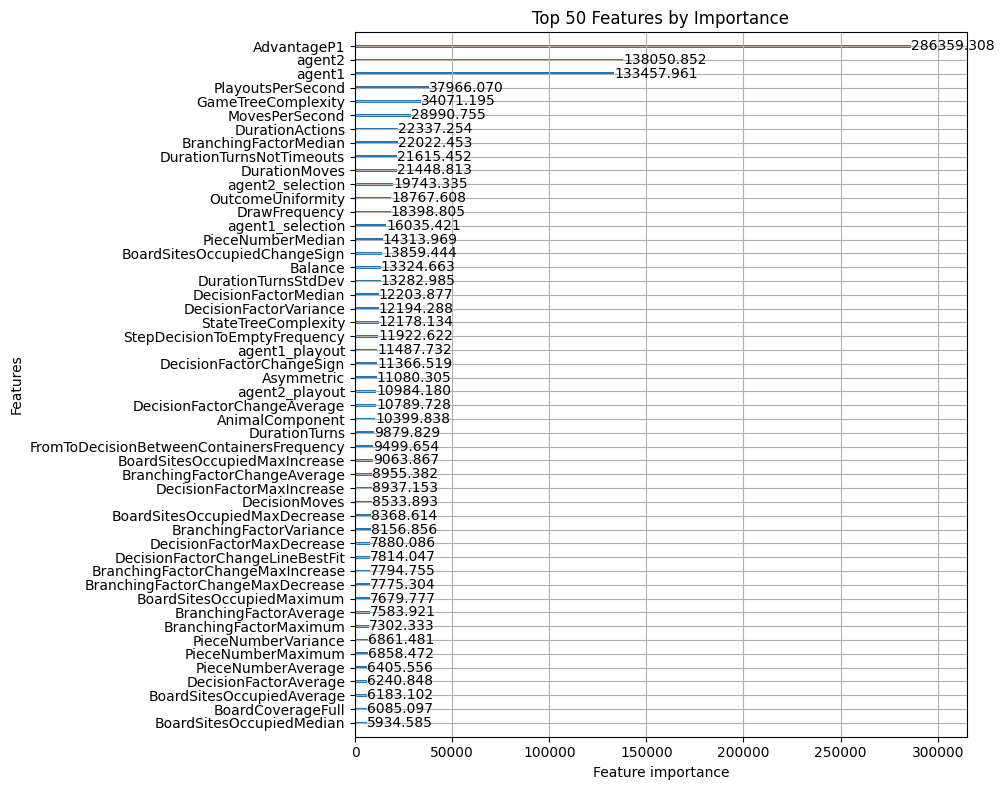

Fold 5 - RMSE: 0.43053214208026985
List of oof scores: [0.41042524972721095, 0.4012625334315349, 0.42989848789168794, 0.43909968447386855, 0.43053214208026985]
Average oof score: 0.4222436195209145


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.502616


[200]	valid_0's rmse: 0.47966


[300]	valid_0's rmse: 0.468787


[400]	valid_0's rmse: 0.462255


[500]	valid_0's rmse: 0.456847


[600]	valid_0's rmse: 0.452991


[700]	valid_0's rmse: 0.450769


[800]	valid_0's rmse: 0.448553


[900]	valid_0's rmse: 0.446724


[1000]	valid_0's rmse: 0.445483


[1100]	valid_0's rmse: 0.444079


[1200]	valid_0's rmse: 0.442927


[1300]	valid_0's rmse: 0.441848


[1400]	valid_0's rmse: 0.441153


[1500]	valid_0's rmse: 0.440455


[1600]	valid_0's rmse: 0.439761


[1700]	valid_0's rmse: 0.439149


[1800]	valid_0's rmse: 0.438549


[1900]	valid_0's rmse: 0.43805


[2000]	valid_0's rmse: 0.43758


[2100]	valid_0's rmse: 0.437254


[2200]	valid_0's rmse: 0.436923


[2300]	valid_0's rmse: 0.436625


[2400]	valid_0's rmse: 0.43624


[2500]	valid_0's rmse: 0.43595


[2600]	valid_0's rmse: 0.435629


[2700]	valid_0's rmse: 0.435262


[2800]	valid_0's rmse: 0.434955


[2900]	valid_0's rmse: 0.434771


[3000]	valid_0's rmse: 0.434576


[3100]	valid_0's rmse: 0.43445


[3200]	valid_0's rmse: 0.434317


[3300]	valid_0's rmse: 0.43428


[3400]	valid_0's rmse: 0.434105


[3500]	valid_0's rmse: 0.433915


[3600]	valid_0's rmse: 0.433691


[3700]	valid_0's rmse: 0.433615


[3800]	valid_0's rmse: 0.433577


[3900]	valid_0's rmse: 0.433419


[4000]	valid_0's rmse: 0.433315


[4100]	valid_0's rmse: 0.433246


[4200]	valid_0's rmse: 0.433163


[4300]	valid_0's rmse: 0.433139


[4400]	valid_0's rmse: 0.433035


[4500]	valid_0's rmse: 0.432959


[4600]	valid_0's rmse: 0.432872


[4700]	valid_0's rmse: 0.432726


[4800]	valid_0's rmse: 0.432655


[4900]	valid_0's rmse: 0.432525


[5000]	valid_0's rmse: 0.432511


[5100]	valid_0's rmse: 0.432436


[5200]	valid_0's rmse: 0.4324


[5300]	valid_0's rmse: 0.432228


[5400]	valid_0's rmse: 0.43223


[5500]	valid_0's rmse: 0.432133


[5600]	valid_0's rmse: 0.432077


[5700]	valid_0's rmse: 0.431993


[5800]	valid_0's rmse: 0.431885


[5900]	valid_0's rmse: 0.431815


[6000]	valid_0's rmse: 0.431741


[6100]	valid_0's rmse: 0.431755


[6200]	valid_0's rmse: 0.431736


[6300]	valid_0's rmse: 0.431656


[6400]	valid_0's rmse: 0.431592


[6500]	valid_0's rmse: 0.431463


[6600]	valid_0's rmse: 0.431414


[6700]	valid_0's rmse: 0.431438


[6800]	valid_0's rmse: 0.431357


[6900]	valid_0's rmse: 0.431263


[7000]	valid_0's rmse: 0.431243


[7100]	valid_0's rmse: 0.431262


[7200]	valid_0's rmse: 0.431218


[7300]	valid_0's rmse: 0.431195


[7400]	valid_0's rmse: 0.431152


[7500]	valid_0's rmse: 0.431143


[7600]	valid_0's rmse: 0.431213


[7700]	valid_0's rmse: 0.431179


[7800]	valid_0's rmse: 0.431111


[7900]	valid_0's rmse: 0.431073


[8000]	valid_0's rmse: 0.431051


[8100]	valid_0's rmse: 0.431036


[8200]	valid_0's rmse: 0.430979


[8300]	valid_0's rmse: 0.430946


[8400]	valid_0's rmse: 0.430897


[8500]	valid_0's rmse: 0.430932


[8600]	valid_0's rmse: 0.430878


[8700]	valid_0's rmse: 0.430813


[8800]	valid_0's rmse: 0.430822


[8900]	valid_0's rmse: 0.430777


[9000]	valid_0's rmse: 0.430778


[9100]	valid_0's rmse: 0.430813


[9200]	valid_0's rmse: 0.430798


[9300]	valid_0's rmse: 0.430771


[9400]	valid_0's rmse: 0.430791


[9500]	valid_0's rmse: 0.430754


[9600]	valid_0's rmse: 0.430726


[9700]	valid_0's rmse: 0.430687


[9800]	valid_0's rmse: 0.430707


[9900]	valid_0's rmse: 0.43072


[10000]	valid_0's rmse: 0.430712


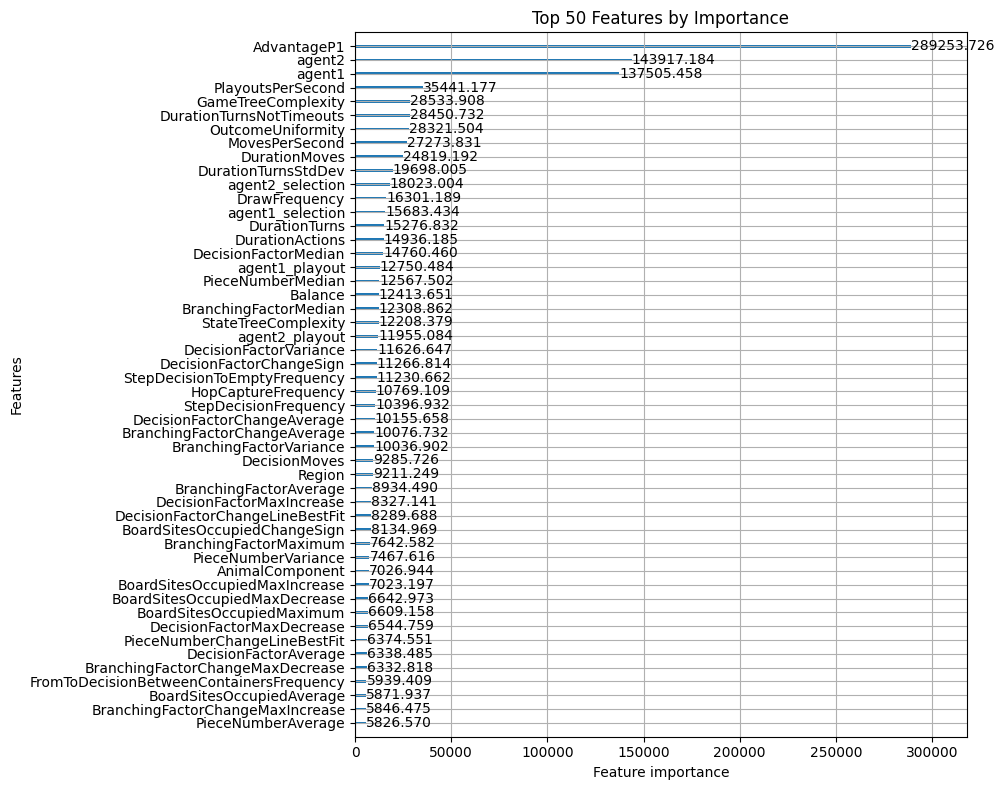

Fold 1 - RMSE: 0.4300565377917163
Fold 2


[100]	valid_0's rmse: 0.503628


[200]	valid_0's rmse: 0.478545


[300]	valid_0's rmse: 0.465443


[400]	valid_0's rmse: 0.456097


[500]	valid_0's rmse: 0.450395


[600]	valid_0's rmse: 0.445705


[700]	valid_0's rmse: 0.442233


[800]	valid_0's rmse: 0.439195


[900]	valid_0's rmse: 0.43694


[1000]	valid_0's rmse: 0.435255


[1100]	valid_0's rmse: 0.433644


[1200]	valid_0's rmse: 0.432072


[1300]	valid_0's rmse: 0.43089


[1400]	valid_0's rmse: 0.429846


[1500]	valid_0's rmse: 0.428721


[1600]	valid_0's rmse: 0.427712


[1700]	valid_0's rmse: 0.426958


[1800]	valid_0's rmse: 0.426365


[1900]	valid_0's rmse: 0.425823


[2000]	valid_0's rmse: 0.425148


[2100]	valid_0's rmse: 0.424554


[2200]	valid_0's rmse: 0.424187


[2300]	valid_0's rmse: 0.423706


[2400]	valid_0's rmse: 0.423268


[2500]	valid_0's rmse: 0.422819


[2600]	valid_0's rmse: 0.422365


[2700]	valid_0's rmse: 0.42194


[2800]	valid_0's rmse: 0.421493


[2900]	valid_0's rmse: 0.421122


[3000]	valid_0's rmse: 0.420777


[3100]	valid_0's rmse: 0.420381


[3200]	valid_0's rmse: 0.420091


[3300]	valid_0's rmse: 0.419679


[3400]	valid_0's rmse: 0.419379


[3500]	valid_0's rmse: 0.419048


[3600]	valid_0's rmse: 0.418895


[3700]	valid_0's rmse: 0.418692


[3800]	valid_0's rmse: 0.418468


[3900]	valid_0's rmse: 0.418355


[4000]	valid_0's rmse: 0.418215


[4100]	valid_0's rmse: 0.418003


[4200]	valid_0's rmse: 0.417896


[4300]	valid_0's rmse: 0.417755


[4400]	valid_0's rmse: 0.417611


[4500]	valid_0's rmse: 0.417466


[4600]	valid_0's rmse: 0.417335


[4700]	valid_0's rmse: 0.417228


[4800]	valid_0's rmse: 0.417031


[4900]	valid_0's rmse: 0.416858


[5000]	valid_0's rmse: 0.416769


[5100]	valid_0's rmse: 0.416735


[5200]	valid_0's rmse: 0.416714


[5300]	valid_0's rmse: 0.416594


[5400]	valid_0's rmse: 0.416489


[5500]	valid_0's rmse: 0.416426


[5600]	valid_0's rmse: 0.416342


[5700]	valid_0's rmse: 0.416334


[5800]	valid_0's rmse: 0.416253


[5900]	valid_0's rmse: 0.416101


[6000]	valid_0's rmse: 0.416059


[6100]	valid_0's rmse: 0.415957


[6200]	valid_0's rmse: 0.415851


[6300]	valid_0's rmse: 0.415715


[6400]	valid_0's rmse: 0.415648


[6500]	valid_0's rmse: 0.415539


[6600]	valid_0's rmse: 0.415493


[6700]	valid_0's rmse: 0.415394


[6800]	valid_0's rmse: 0.415307


[6900]	valid_0's rmse: 0.415288


[7000]	valid_0's rmse: 0.415223


[7100]	valid_0's rmse: 0.415161


[7200]	valid_0's rmse: 0.41506


[7300]	valid_0's rmse: 0.415027


[7400]	valid_0's rmse: 0.414953


[7500]	valid_0's rmse: 0.414925


[7600]	valid_0's rmse: 0.414907


[7700]	valid_0's rmse: 0.414863


[7800]	valid_0's rmse: 0.414795


[7900]	valid_0's rmse: 0.414785


[8000]	valid_0's rmse: 0.414732


[8100]	valid_0's rmse: 0.414704


[8200]	valid_0's rmse: 0.414711


[8300]	valid_0's rmse: 0.414648


[8400]	valid_0's rmse: 0.414618


[8500]	valid_0's rmse: 0.41458


[8600]	valid_0's rmse: 0.414538


[8700]	valid_0's rmse: 0.414469


[8800]	valid_0's rmse: 0.414448


[8900]	valid_0's rmse: 0.414403


[9000]	valid_0's rmse: 0.414365


[9100]	valid_0's rmse: 0.414339


[9200]	valid_0's rmse: 0.414341


[9300]	valid_0's rmse: 0.41435


[9400]	valid_0's rmse: 0.414352


[9500]	valid_0's rmse: 0.414312


[9600]	valid_0's rmse: 0.414302


[9700]	valid_0's rmse: 0.414298


[9800]	valid_0's rmse: 0.414241


[9900]	valid_0's rmse: 0.414247


[10000]	valid_0's rmse: 0.414261


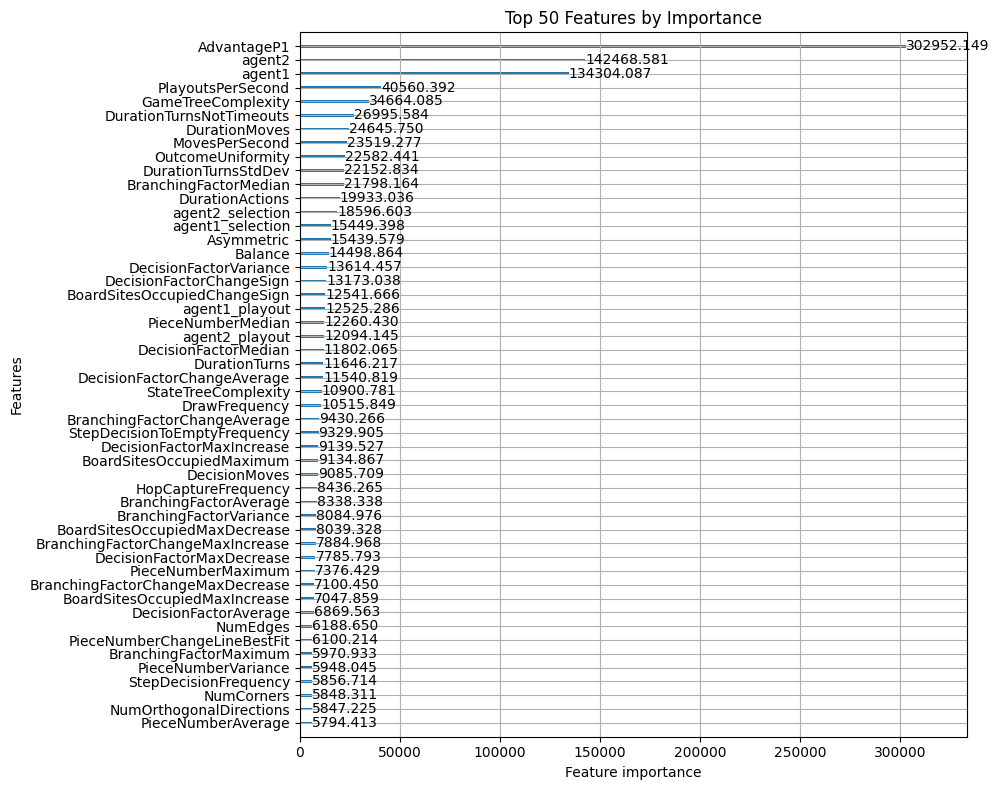

Fold 2 - RMSE: 0.4138478662848806
Fold 3


[100]	valid_0's rmse: 0.494486


[200]	valid_0's rmse: 0.470719


[300]	valid_0's rmse: 0.459389


[400]	valid_0's rmse: 0.451759


[500]	valid_0's rmse: 0.44677


[600]	valid_0's rmse: 0.443428


[700]	valid_0's rmse: 0.440894


[800]	valid_0's rmse: 0.438243


[900]	valid_0's rmse: 0.43651


[1000]	valid_0's rmse: 0.43505


[1100]	valid_0's rmse: 0.433687


[1200]	valid_0's rmse: 0.432917


[1300]	valid_0's rmse: 0.43206


[1400]	valid_0's rmse: 0.431126


[1500]	valid_0's rmse: 0.430488


[1600]	valid_0's rmse: 0.429652


[1700]	valid_0's rmse: 0.429164


[1800]	valid_0's rmse: 0.42874


[1900]	valid_0's rmse: 0.428366


[2000]	valid_0's rmse: 0.427923


[2100]	valid_0's rmse: 0.427506


[2200]	valid_0's rmse: 0.427212


[2300]	valid_0's rmse: 0.426866


[2400]	valid_0's rmse: 0.426473


[2500]	valid_0's rmse: 0.426239


[2600]	valid_0's rmse: 0.42596


[2700]	valid_0's rmse: 0.42584


[2800]	valid_0's rmse: 0.425515


[2900]	valid_0's rmse: 0.425215


[3000]	valid_0's rmse: 0.425053


[3100]	valid_0's rmse: 0.424726


[3200]	valid_0's rmse: 0.424518


[3300]	valid_0's rmse: 0.424341


[3400]	valid_0's rmse: 0.424047


[3500]	valid_0's rmse: 0.42381


[3600]	valid_0's rmse: 0.423583


[3700]	valid_0's rmse: 0.423461


[3800]	valid_0's rmse: 0.423398


[3900]	valid_0's rmse: 0.423138


[4000]	valid_0's rmse: 0.423021


[4100]	valid_0's rmse: 0.422927


[4200]	valid_0's rmse: 0.422962


[4300]	valid_0's rmse: 0.422817


[4400]	valid_0's rmse: 0.422771


[4500]	valid_0's rmse: 0.422616


[4600]	valid_0's rmse: 0.422506


[4700]	valid_0's rmse: 0.422471


[4800]	valid_0's rmse: 0.422335


[4900]	valid_0's rmse: 0.422187


[5000]	valid_0's rmse: 0.422191


[5100]	valid_0's rmse: 0.422183


[5200]	valid_0's rmse: 0.422024


[5300]	valid_0's rmse: 0.421972


[5400]	valid_0's rmse: 0.421892


[5500]	valid_0's rmse: 0.421828


[5600]	valid_0's rmse: 0.421758


[5700]	valid_0's rmse: 0.421698


[5800]	valid_0's rmse: 0.421746


[5900]	valid_0's rmse: 0.421622


[6000]	valid_0's rmse: 0.42149


[6100]	valid_0's rmse: 0.421496


[6200]	valid_0's rmse: 0.421447


[6300]	valid_0's rmse: 0.421441


[6400]	valid_0's rmse: 0.421337


[6500]	valid_0's rmse: 0.421309


[6600]	valid_0's rmse: 0.421171


[6700]	valid_0's rmse: 0.421139


[6800]	valid_0's rmse: 0.421197


[6900]	valid_0's rmse: 0.421173


[7000]	valid_0's rmse: 0.421152


[7100]	valid_0's rmse: 0.421136


[7200]	valid_0's rmse: 0.421117


[7300]	valid_0's rmse: 0.421046


[7400]	valid_0's rmse: 0.420969


[7500]	valid_0's rmse: 0.420917


[7600]	valid_0's rmse: 0.420941


[7700]	valid_0's rmse: 0.420931


[7800]	valid_0's rmse: 0.420928


[7900]	valid_0's rmse: 0.420882


[8000]	valid_0's rmse: 0.420853


[8100]	valid_0's rmse: 0.420891


[8200]	valid_0's rmse: 0.4209


[8300]	valid_0's rmse: 0.420857


[8400]	valid_0's rmse: 0.420787


[8500]	valid_0's rmse: 0.420756


[8600]	valid_0's rmse: 0.420727


[8700]	valid_0's rmse: 0.420659


[8800]	valid_0's rmse: 0.420662


[8900]	valid_0's rmse: 0.420628


[9000]	valid_0's rmse: 0.420625


[9100]	valid_0's rmse: 0.420635


[9200]	valid_0's rmse: 0.42059


[9300]	valid_0's rmse: 0.420566


[9400]	valid_0's rmse: 0.420578


[9500]	valid_0's rmse: 0.420522


[9600]	valid_0's rmse: 0.420504


[9700]	valid_0's rmse: 0.42047


[9800]	valid_0's rmse: 0.420451


[9900]	valid_0's rmse: 0.420444


[10000]	valid_0's rmse: 0.420369


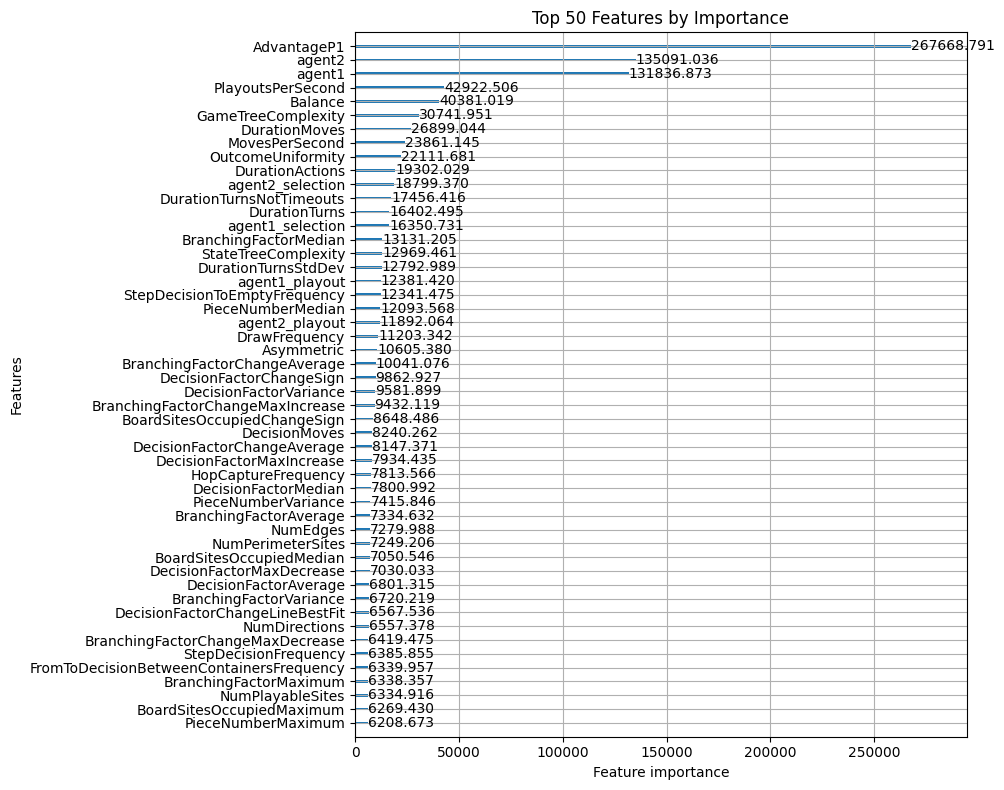

Fold 3 - RMSE: 0.41988206543583306
Fold 4


[100]	valid_0's rmse: 0.485342


[200]	valid_0's rmse: 0.464069


[300]	valid_0's rmse: 0.452845


[400]	valid_0's rmse: 0.445714


[500]	valid_0's rmse: 0.441391


[600]	valid_0's rmse: 0.437857


[700]	valid_0's rmse: 0.434907


[800]	valid_0's rmse: 0.432597


[900]	valid_0's rmse: 0.430636


[1000]	valid_0's rmse: 0.428981


[1100]	valid_0's rmse: 0.427744


[1200]	valid_0's rmse: 0.426619


[1300]	valid_0's rmse: 0.425609


[1400]	valid_0's rmse: 0.424783


[1500]	valid_0's rmse: 0.424043


[1600]	valid_0's rmse: 0.423432


[1700]	valid_0's rmse: 0.422792


[1800]	valid_0's rmse: 0.422247


[1900]	valid_0's rmse: 0.421775


[2000]	valid_0's rmse: 0.421375


[2100]	valid_0's rmse: 0.420924


[2200]	valid_0's rmse: 0.420614


[2300]	valid_0's rmse: 0.420265


[2400]	valid_0's rmse: 0.419938


[2500]	valid_0's rmse: 0.419677


[2600]	valid_0's rmse: 0.419435


[2700]	valid_0's rmse: 0.419125


[2800]	valid_0's rmse: 0.418951


[2900]	valid_0's rmse: 0.418624


[3000]	valid_0's rmse: 0.418385


[3100]	valid_0's rmse: 0.41813


[3200]	valid_0's rmse: 0.417941


[3300]	valid_0's rmse: 0.417773


[3400]	valid_0's rmse: 0.417636


[3500]	valid_0's rmse: 0.417451


[3600]	valid_0's rmse: 0.41728


[3700]	valid_0's rmse: 0.417123


[3800]	valid_0's rmse: 0.417011


[3900]	valid_0's rmse: 0.416815


[4000]	valid_0's rmse: 0.416779


[4100]	valid_0's rmse: 0.416648


[4200]	valid_0's rmse: 0.416507


[4300]	valid_0's rmse: 0.416393


[4400]	valid_0's rmse: 0.416273


[4500]	valid_0's rmse: 0.416219


[4600]	valid_0's rmse: 0.416114


[4700]	valid_0's rmse: 0.416047


[4800]	valid_0's rmse: 0.415956


[4900]	valid_0's rmse: 0.41587


[5000]	valid_0's rmse: 0.415789


[5100]	valid_0's rmse: 0.41577


[5200]	valid_0's rmse: 0.415684


[5300]	valid_0's rmse: 0.415532


[5400]	valid_0's rmse: 0.415442


[5500]	valid_0's rmse: 0.41539


[5600]	valid_0's rmse: 0.415308


[5700]	valid_0's rmse: 0.415276


[5800]	valid_0's rmse: 0.415248


[5900]	valid_0's rmse: 0.41514


[6000]	valid_0's rmse: 0.415064


[6100]	valid_0's rmse: 0.414991


[6200]	valid_0's rmse: 0.414939


[6300]	valid_0's rmse: 0.414903


[6400]	valid_0's rmse: 0.414875


[6500]	valid_0's rmse: 0.414866


[6600]	valid_0's rmse: 0.41485


[6700]	valid_0's rmse: 0.414737


[6800]	valid_0's rmse: 0.414687


[6900]	valid_0's rmse: 0.414631


[7000]	valid_0's rmse: 0.414547


[7100]	valid_0's rmse: 0.414495


[7200]	valid_0's rmse: 0.414474


[7300]	valid_0's rmse: 0.414413


[7400]	valid_0's rmse: 0.414382


[7500]	valid_0's rmse: 0.414342


[7600]	valid_0's rmse: 0.414259


[7700]	valid_0's rmse: 0.414208


[7800]	valid_0's rmse: 0.414134


[7900]	valid_0's rmse: 0.414171


[8000]	valid_0's rmse: 0.414182


[8100]	valid_0's rmse: 0.414123


[8200]	valid_0's rmse: 0.414097


[8300]	valid_0's rmse: 0.414088


[8400]	valid_0's rmse: 0.414055


[8500]	valid_0's rmse: 0.414051


[8600]	valid_0's rmse: 0.414045


[8700]	valid_0's rmse: 0.414045


[8800]	valid_0's rmse: 0.414059


[8900]	valid_0's rmse: 0.414028


[9000]	valid_0's rmse: 0.414067


[9100]	valid_0's rmse: 0.41405


[9200]	valid_0's rmse: 0.414069


[9300]	valid_0's rmse: 0.41403


[9400]	valid_0's rmse: 0.413981


[9500]	valid_0's rmse: 0.413937


[9600]	valid_0's rmse: 0.413929


[9700]	valid_0's rmse: 0.413912


[9800]	valid_0's rmse: 0.413896


[9900]	valid_0's rmse: 0.413885


[10000]	valid_0's rmse: 0.413881


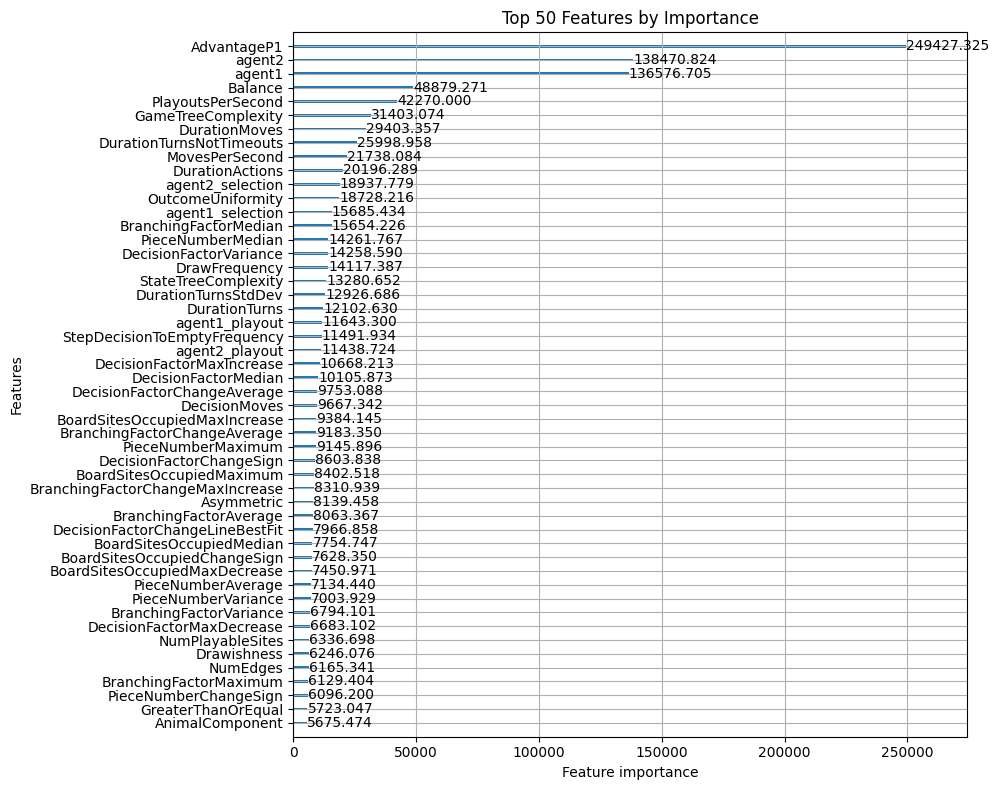

Fold 4 - RMSE: 0.4132667185260489
Fold 5


[100]	valid_0's rmse: 0.508504


[200]	valid_0's rmse: 0.487321


[300]	valid_0's rmse: 0.476806


[400]	valid_0's rmse: 0.469054


[500]	valid_0's rmse: 0.463075


[600]	valid_0's rmse: 0.458234


[700]	valid_0's rmse: 0.454286


[800]	valid_0's rmse: 0.451232


[900]	valid_0's rmse: 0.448825


[1000]	valid_0's rmse: 0.446426


[1100]	valid_0's rmse: 0.444602


[1200]	valid_0's rmse: 0.443055


[1300]	valid_0's rmse: 0.441725


[1400]	valid_0's rmse: 0.440843


[1500]	valid_0's rmse: 0.439588


[1600]	valid_0's rmse: 0.438764


[1700]	valid_0's rmse: 0.4379


[1800]	valid_0's rmse: 0.43722


[1900]	valid_0's rmse: 0.436433


[2000]	valid_0's rmse: 0.435933


[2100]	valid_0's rmse: 0.43518


[2200]	valid_0's rmse: 0.434642


[2300]	valid_0's rmse: 0.43409


[2400]	valid_0's rmse: 0.433742


[2500]	valid_0's rmse: 0.433225


[2600]	valid_0's rmse: 0.432842


[2700]	valid_0's rmse: 0.432576


[2800]	valid_0's rmse: 0.432209


[2900]	valid_0's rmse: 0.431851


[3000]	valid_0's rmse: 0.431616


[3100]	valid_0's rmse: 0.431275


[3200]	valid_0's rmse: 0.430989


[3300]	valid_0's rmse: 0.430739


[3400]	valid_0's rmse: 0.430458


[3500]	valid_0's rmse: 0.430346


[3600]	valid_0's rmse: 0.430154


[3700]	valid_0's rmse: 0.429944


[3800]	valid_0's rmse: 0.429783


[3900]	valid_0's rmse: 0.429576


[4000]	valid_0's rmse: 0.42948


[4100]	valid_0's rmse: 0.429272


[4200]	valid_0's rmse: 0.429082


[4300]	valid_0's rmse: 0.428962


[4400]	valid_0's rmse: 0.428851


[4500]	valid_0's rmse: 0.428622


[4600]	valid_0's rmse: 0.428534


[4700]	valid_0's rmse: 0.428352


[4800]	valid_0's rmse: 0.428257


[4900]	valid_0's rmse: 0.428101


[5000]	valid_0's rmse: 0.428001


[5100]	valid_0's rmse: 0.427917


[5200]	valid_0's rmse: 0.427836


[5300]	valid_0's rmse: 0.427726


[5400]	valid_0's rmse: 0.427591


[5500]	valid_0's rmse: 0.427511


[5600]	valid_0's rmse: 0.427394


[5700]	valid_0's rmse: 0.427289


[5800]	valid_0's rmse: 0.427218


[5900]	valid_0's rmse: 0.427094


[6000]	valid_0's rmse: 0.427066


[6100]	valid_0's rmse: 0.427065


[6200]	valid_0's rmse: 0.426974


[6300]	valid_0's rmse: 0.426917


[6400]	valid_0's rmse: 0.426834


[6500]	valid_0's rmse: 0.426787


[6600]	valid_0's rmse: 0.426815


[6700]	valid_0's rmse: 0.426774


[6800]	valid_0's rmse: 0.426716


[6900]	valid_0's rmse: 0.4266


[7000]	valid_0's rmse: 0.426602


[7100]	valid_0's rmse: 0.426521


[7200]	valid_0's rmse: 0.426448


[7300]	valid_0's rmse: 0.426427


[7400]	valid_0's rmse: 0.426316


[7500]	valid_0's rmse: 0.426255


[7600]	valid_0's rmse: 0.426251


[7700]	valid_0's rmse: 0.426203


[7800]	valid_0's rmse: 0.426123


[7900]	valid_0's rmse: 0.426064


[8000]	valid_0's rmse: 0.42606


[8100]	valid_0's rmse: 0.42603


[8200]	valid_0's rmse: 0.426025


[8300]	valid_0's rmse: 0.426


[8400]	valid_0's rmse: 0.42598


[8500]	valid_0's rmse: 0.425952


[8600]	valid_0's rmse: 0.425872


[8700]	valid_0's rmse: 0.425874


[8800]	valid_0's rmse: 0.425851


[8900]	valid_0's rmse: 0.42583


[9000]	valid_0's rmse: 0.425803


[9100]	valid_0's rmse: 0.425812


[9200]	valid_0's rmse: 0.425852


[9300]	valid_0's rmse: 0.42582


[9400]	valid_0's rmse: 0.425818


[9500]	valid_0's rmse: 0.425805


[9600]	valid_0's rmse: 0.425771


[9700]	valid_0's rmse: 0.425807


[9800]	valid_0's rmse: 0.425874


[9900]	valid_0's rmse: 0.425844


[10000]	valid_0's rmse: 0.425792


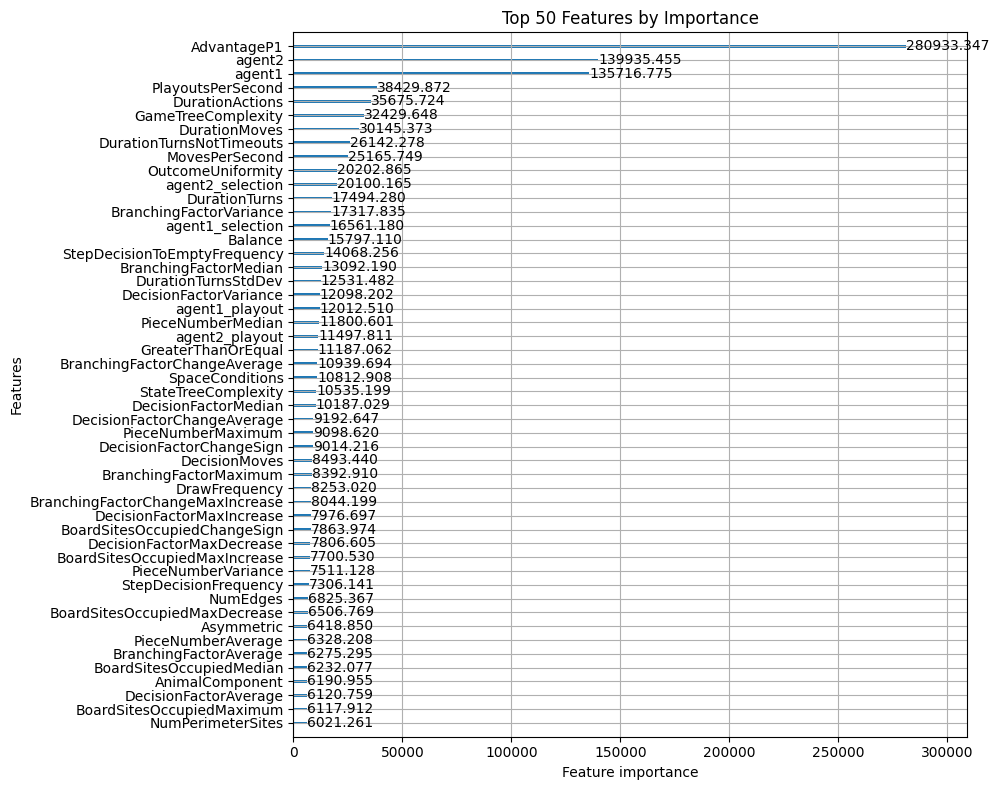

Fold 5 - RMSE: 0.4251730460962075
List of oof scores: [0.4300565377917163, 0.4138478662848806, 0.41988206543583306, 0.4132667185260489, 0.4251730460962075]
Average oof score: 0.42044524682693724


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4224
Score: 0.4481
Score: 0.4379
Score: 0.4344
Score: 0.4027
Average CV1 Score: 0.4291

CV2 OOF Scores:
Score: 0.4104
Score: 0.4013
Score: 0.4299
Score: 0.4391
Score: 0.4305
Average CV2 Score: 0.4222

CV3 OOF Scores:
Score: 0.4301
Score: 0.4138
Score: 0.4199
Score: 0.4133
Score: 0.4252
Average CV3 Score: 0.4204


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

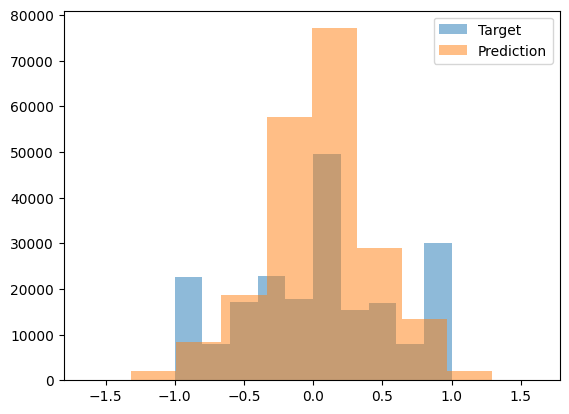

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.145669       │
│ 233235 ┆ -0.189214      │
│ 233236 ┆ -0.008943      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***